In [1]:
#This part of the code is used for import libraries which we are using later
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import xlsxwriter
import matplotlib.pyplot as plt
#from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf 
import math

In [2]:
import smtplib
from email.message import EmailMessage


In [3]:
# function nacitaj data is used for declaring main dataset 
def nacitaj_data():
    global df #dataframe ockovanie
    df= pd.read_csv("https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/Vaccination/OpenData_Slovakia_Vaccination_AgeGroup_District_comma.csv")
    #df.to_excel('pokus.xlsx')
    global pop #populacia
    #excel="D:\Datapython\pop.xlsx"
    pop_list= {'AgeGroup':['80+','75-79','70-74','65-69','60-64','55-59','50-54','45-49','40-44','35-39','30-34','25-29','20-24','60+','60-'],'populacia':[189121,160295,247632,334976,353682,356041,345716,414217,453932,433922,403000,350572,286207,1285706,3043607]} 
    pop=pd.DataFrame(pop_list)
    # pop= pd.read_excel(excel, 'Sheet1') 
   # pop=pop[['AgeGroup','populacia']]
   # global demo #demografia
   # demo= pd.read_excel (excel, 'Demografia') 
        
nacitaj_data()

In [4]:
def prehlad_ockovanie_sumar():
    nacitaj_data() # to initial dataset
# declaring the order of doses. List allows us to append another dose if neccesary. 

    doses = ["1","2","3"] 

    for x in doses: #for cycle overage of vaccine uptake in age groups in respect with doses
        #selecting by age groub and by dose and agregating 
        select=df[(( (df.dose==x)) & (df.vaccine!='') )].groupby(['AgeGroup']) [['doses_administered',]].sum() 
        
        #sorting values
        select=select.sort_values(by='AgeGroup', ascending=False)  
   
        
        if x=="1":
            global result
            #merging selected dataframe with population dataframe 
            result = pd.merge(select, pop, how="left",on=["AgeGroup"] ) 
            #string linking 
            concat=x+".dose_administered"
            #column renaming 
            result= result.rename(columns={"doses_administered":concat})
           
            #same as above 
        else:
            result = pd.merge(result, select, how="left",on=["AgeGroup"] )
            concat=x+".dose_administered"
            result= result.rename(columns={"doses_administered":concat})
    #selecting one shot vaccine, J&J       
    select=df[(( (df.dose=='1')) & (df.vaccine=='JANSSEN')& (df.AgeGroup!='5-9')& (df.AgeGroup!='18-19')& (df.AgeGroup!='15-17')& (df.AgeGroup!='10-14'))].groupby(['AgeGroup']) [['doses_administered',]].sum()
    select=select.sort_values(by='AgeGroup', ascending=False)
    result= pd.merge(result, select, how="left",on=["AgeGroup"] )
    result= result.rename(columns={"doses_administered":"J&J"})
            
    result["zaockovanost"]= result["1.dose_administered"] / result["populacia"] #vac uptake at least one dose

    result["zaockovanost 3. davkou"]= result["3.dose_administered"] / result["populacia"] #booster  uptake
    
    result["preockovanost 3. davkou"]= result["3.dose_administered"] / result["1.dose_administered"] #booster uptake in population which has at least one dose
     
    lists=["zaockovanost","zaockovanost 3. davkou", "preockovanost 3. davkou"]
    for x in lists:
        result[x] = result[x].astype(float).map("{:.3%}".format) #formating columns as % with 3 decimal numbers 
    
    #rearanging dataframe 
    result=result[['AgeGroup','populacia','1.dose_administered','J&J','2.dose_administered','3.dose_administered','zaockovanost','zaockovanost 3. davkou', 'preockovanost 3. davkou']]
    
    #result storage in excel
    result.to_excel('pokus_skupiny2.xlsx')
    #send_mail_with_excel("pet.kravec@gmail.com","pokus","pokus_skupiny2.xlsx" )
    print('hotovo prehlad_ockovanie_sumar')


In [5]:
#this function is used for make overview of vaccination uptake in week in each of requested age group. 
#dataframe for each dose is copied into the separate sheet in excel. 
#the result of the function is, in addition to the .xlsx file, also a list of dataframes, each dataframe is for each batch 

def Ockovanie_Tyzdenne():
    global list_df
    list_df = {}
    
    #obtaining distinct age group from original dataframe in descending form, will be used in for cycle later.
    result= df.loc[((df.AgeGroup!='5-9')&(df.AgeGroup!='nan')& (df.AgeGroup!='15-17')& (df.AgeGroup!='10-14')),["AgeGroup"]].drop_duplicates().sort_values(by='AgeGroup', ascending=False)
    global agegroups
    agegroups=result["AgeGroup"].tolist() #selected df to list 
    doses = ["1","2","3"]
    
    with pd.ExcelWriter('output_SR.xlsx') as writer:   #open excel to write
        
        for x in doses: #for each dose
            
            result=df[['week']].drop_duplicates() # the number of the week as the first column in which we can merge selections made later 

            for y in agegroups:
                # selecting, merging, renaming, sorting 
                select=df[( (df.dose==x) & (df.vaccine!='') & (df.AgeGroup==y)) ].groupby(['week']) [['doses_administered',]].sum()
                result = pd.merge(result, select, how="left",on=['week'])
                result= result.rename(columns={"doses_administered":y})
                result=result.sort_values(by=['week'])

            list_df[int(x)]=result   
            
            if int(x)==3:
                
                tyzden=int(date.today().strftime("%V"))+19   #Booster shots were available in October, so we're skipping the first few weeks  
                list_df[int(x)]=list_df[int(x)].tail(tyzden)
                list_df[int(x)].to_excel(writer, sheet_name=x,index='none')

            else:
                list_df[int(x)].to_excel(writer, sheet_name=x,index='none') 
        
    print('hotovo Ockovanie_Tyzdenne')

    
 #this function is using list of dataframes, which were made in function Ockovanie_Tyzdenne() to further processing for now is used only for the first doses since we are interested mainly in those. By little changes we are able to adjust script for same structure for each dose 
def Ockovanie_Tyzdenne_zostatok():
    global result1
    result1=pd.DataFrame()
    for x in range(1,4):
        
        result=list_df[x]
        
        for y in agegroups:
            t="zvyšok "+str(y)
            try:
                popu=pop.loc[pop.AgeGroup==y,'populacia'].values[0]
            except:
                print()
            else:    
                if x==1:
                    result[t] = popu - result[y].cumsum() # how many people are left unvaccinated   
                    tt='podiel nezaockova '+str(y)  
                    result[tt] = result[y]/result[t].shift(+1) # % of vaccinated people in given week-t from people which were not vaccinated week before - (t-1)
                    ttt='cumulative '+str(y)
                    result1[ttt] =result[y].cumsum() #cumulative sum of vaccinated people
                    result.to_excel('output_extended.xlsx') # result to excel
                #elif x==2:
                     #dopracovat result[t] = list_df[1] [y].cumsum() - result[y].cumsum()
               
        
        list_df[x]=result # rewrite the original dataframe (x-th dataframe in list)
        #result.to_excel('output_extended.xlsx')
 


In [6]:
%%time
Ockovanie_Tyzdenne()
#prehlad_ockovanie_sumar()
Ockovanie_Tyzdenne_zostatok()


hotovo Ockovanie_Tyzdenne






Wall time: 7.88 s


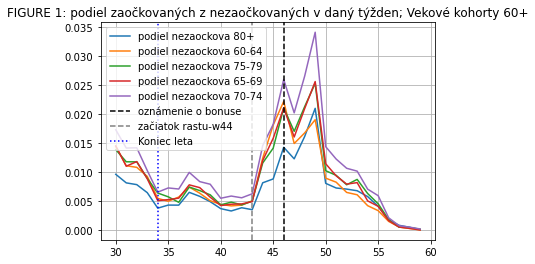

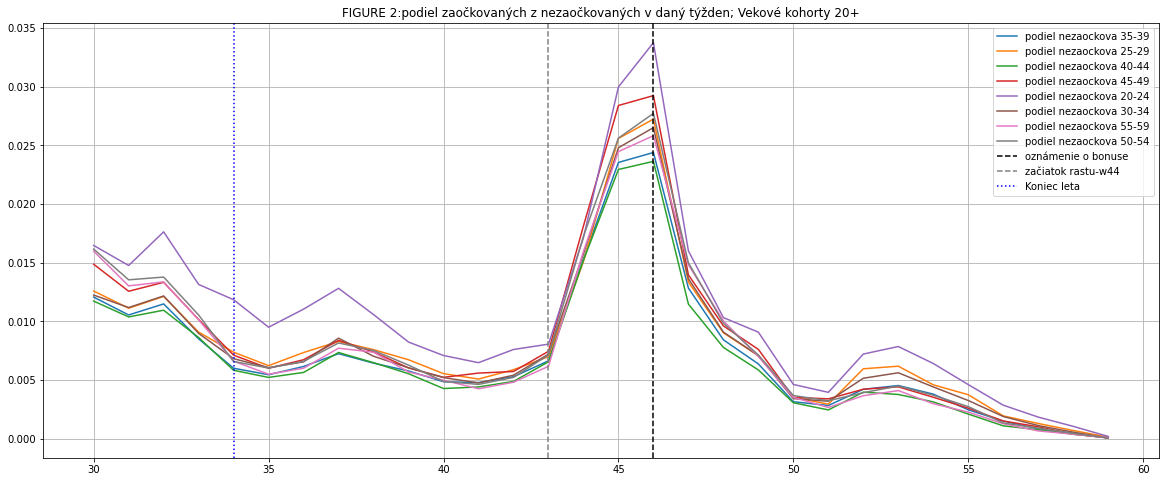

In [7]:
#following the function Ockovanie_Tyzdenne_zostatok() ploting the % of vaccinated people in given week-t from people which were not vaccinated week before - (t-1)

stlpce={}
df1=list_df[1] [{'podiel nezaockova 80+','podiel nezaockova 75-79','podiel nezaockova 70-74','podiel nezaockova 65-69','podiel nezaockova 60-64'}]#.tail(25)
stlpce=df1.columns.values.tolist()
df1=df1.tail(30)


fig, ax = plt.subplots()
plt.title('FIGURE 1: podiel zaočkovaných z nezaočkovaných v daný týžden; Vekové kohorty 60+')

for x in stlpce:
    ax.plot( df1 [x],label = x)
plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
plt.axvline(x = 34, color = 'blue', linestyle=':',label = 'Koniec leta')
ax.grid(True)
plt.legend()
plt.rcParams["figure.figsize"] = (20,8)
plt.yscale("linear")
plt.show()




df2=list_df[1] [{'podiel nezaockova 50-54','podiel nezaockova 55-59','podiel nezaockova 40-44','podiel nezaockova 45-49','podiel nezaockova 35-39','podiel nezaockova 30-34','podiel nezaockova 25-29','podiel nezaockova 20-24'}]#.tail(25)
stlpce=df2.columns.values.tolist()
df2=df2.tail(30)

fig, ax = plt.subplots()
plt.title('FIGURE 2:podiel zaočkovaných z nezaočkovaných v daný týžden; Vekové kohorty 20+')
for x in stlpce:
    ax.plot( df2 [x],label = x)
ax.grid(True)
plt.legend(df2.columns,)
plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
plt.axvline(x = 34, color = 'blue', linestyle=':',label = 'Koniec leta')
plt.legend()
plt.rcParams["figure.figsize"] = (20,8)
plt.yscale("linear")
plt.show()


In [8]:
#processing dataset about pacients in hospitals
df3=pd.DataFrame()
url='https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/Hospitals/OpenData_Slovakia_Covid_Hospital_AdmissionDischarge_Regions.csv'
df3 = pd.read_csv(url,sep=';') #github csv to the datafrem 
df3.drop('Unnamed: 0',inplace=True,axis=1) #dropping unnamed column
df3['formatted_date'] = pd.to_datetime(df3['Date']) #making sure that date in csv is properly formated for next procesing
df3['week'] = df3.formatted_date.apply(lambda x: x.weekofyear) #week of the year to match(or join ) the vaccination data on the graph
df3['year']= df3['formatted_date'].dt.year #year since vac. begin in 2020
df3=df3[(df3["year"]!=2020)] # dropping 2020 data away the dataset of vacc begins as first week of 2021.
df3.loc[(df3['year'] == 2022)&(df3['week']<52), 'week'] = df3['week']+52 # to index data as week of the vaccination ie. first week of 2021 is 1st week, but 1st week 2022 is the 53th of vaccination in slovakia
df3.loc[(df3['year'] == 2021)&(df3['week']==53), 'week'] = 1 # agregatting the data from w53-2021 (actually w53-2020)to the w1 2021
df3=df3.groupby(['week']) [['Admissions']].sum() #admissions by week
df3=df3.reset_index() #reseting index
df3=df3.drop('week', axis=1) # preparation to the ploting on the graphs


In [9]:
    df2=pd.DataFrame()

    url="https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/PCR_Tests/OpenData_Slovakia_Covid_PCRTests_District.csv"
    df2= pd.read_csv(url,sep=';')

    df2['formatted_date'] = pd.to_datetime(df2['Date'])
    df2=df2.drop('Date',axis=1)
    #df1['day_of_year'] = df1.formatted_date.apply(lambda x: x.dayofyear)
    df2['week'] = df2.formatted_date.apply(lambda x: x.weekofyear)
    df2['year']= df2['formatted_date'].dt.year

    df2=df2[(df2["year"]!=2020)]
    df2.loc[(df2['year'] == 2022)&(df2['week']<52), 'week'] = df2['week']+52
    df2.loc[(df2['year'] == 2021)&(df2['week']==53), 'week'] = 1
    df2=df2.groupby(['week']) [['PCR_Pos']].sum()
    df2=df2.reset_index()
    df2=df2.drop('week', axis=1)
#the same principle as above, the change is loading data from the xlsx from the local computer.

In [10]:
##density function for bass model

def densityFunction(p, q, t):
    return (np.exp((p+q)*t)*p*(p+q)**2)/((p*np.exp((p+q)*t)+q)**2)


# (p*(np.exp((p+q)*t)-1)/(p*np.exp((p+q)*t)+q))

In [11]:
#definition of agegroups for the bass model and belonging start of the vac. 
df_bk=pd.DataFrame()
def Bass_setup():
    return( {'AgeGroup':['80+','75-79','70-74','65-69','60-64','55-59','50-54','45-49','40-44','35-39','30-34','25-29','20-24','60+','60-'],'zac':[0,0,7,7,7,7,7,10,11,12,13,13,13,2,5]} ) #definovanie DF kohorty kohorta 

In [12]:
def bass(kohorta):
#### definition of variables/ dataframes####    
    global data1,data,df_bk,cdf, graf_2
    cdf=[]
    data=pd.DataFrame()
    data1=pd.DataFrame()
    df2_1=pd.DataFrame()
    df3_1=pd.DataFrame()
    df_bk=pd.DataFrame()
    graf_3=pd.DataFrame()
    graf_2=pd.DataFrame()
    a=0
    global xy,xyz,w,rozdiel,sucet_prvych,rozdiel1
    xy=0
    xyz=0
    w=0
    sucet_prvych=0
    today=date.today()
    w=today.isocalendar()[1]+52  # Number of weeks since the start of the vaccination in Slovakia
   
    df_bk=pd.DataFrame(Bass_setup())
    df_bk=pd.merge(df_bk, pop, how="left",on=["AgeGroup"])
    
    xy=w-df_bk.loc[df_bk.AgeGroup==kohorta,'zac'].values[0] #the number of weeks taken into account for a given age category, ie the last xy, can be omitted several weeks from the beginning, vaccination took place chronologically from oldest to youngest, but some professions, especially medical, were vaccinated preferentially. 
    xyz=47-df_bk.loc[df_bk.AgeGroup==kohorta,'zac'].values[0] ##the number of weeks taken into account for OLS estimate (to account just weeks from the start of vaccination in given age group to week 47)
    
    
#### preparation of the data to OLS and for the graphs####  
    if kohorta=='60+':   
        data['y']= list_df[1] ['75-79'] + list_df[1] ['80+'] + list_df[1] ['70-74'] +list_df[1] ['65-69']+list_df[1] ['60-64']
   
    elif kohorta=='60-':
        data['y']= list_df[1] ['20-24']+list_df[1] ['25-29']+list_df[1] ['30-34']+list_df[1] ['35-39'] + list_df[1] ['40-44'] + list_df[1] ['45-49'] +list_df[1] ['55-59']+list_df[1] ['50-54'] 
    
    else:
        data['y']=list_df[1] [kohorta]
        
    if data['y'].tail(1).isnull().sum() == 1 :    #On mondays there are empty row which may cause a trouble in making graphs
        w=w-1
        data=data.dropna()

    sucet_prvych=data.head(w-xy).sum()

    data=data.tail(xy) #removes the observation from the beginning of vaccination when vaccination was not yet available to the general public  // according to age group
    df2_1=df2.tail(xy) 
    df3_1=df3.tail(xy) 

    data['x_1']=data['y'].cumsum()
    data['x_2']=data['x_1']**2         #priprava dát pre OLS 

    graf_3=data['y'] #  saving the real data, will be used in making plots, 
    graf_2=data['x_1']  #same as above cumulative sum

    data1=data.head(xyz) #takes the k-first weeks depending on what period the forecast is to be made. 
  
    #### OLS ESTIMATE OF BASS MODEL COEFF####  
    
    model_ols=smf.ols(formula='y ~ x_1 + x_2', data=data1) #Simple OLS model to estimate coeficient of the model.  
    result_ols=model_ols.fit()  
    #result_ols.summary()
    parameter=result_ols.params 
    
    
    #### BASS MODEL - calibration####
    
    
    m_1=(-parameter['x_1']+np.sqrt(parameter['x_1']**2 - 4*parameter['Intercept']*parameter['x_2']))/(2*parameter['x_2'])
    m_2=(-parameter['x_1']-np.sqrt(parameter['x_1']**2 - 4*parameter['Intercept']*parameter['x_2']))/(2*parameter['x_2'])
    #solving quadratic equation. (diskriminant )
    m=max(m_1,m_2) # Calculation of the population capturing the solution in our case, the vaccination.
    
    p=parameter['Intercept'] / m #calibration - p
    q= -m*parameter['x_2'] #calibration - q
    print('p: ',p,' q: ',q, ' m: ',m)
    t= range(0, xy, 1) # range to make input to the density function (BASS model) - t represent time periods

    f = densityFunction(p,q,t) #Calculation of density function 
    
    sales_forecast = m*f #Counterfactual weekly vaccination uptake according to the bass model
    cdf = np.cumsum(sales_forecast) # Counterfactual CDF
    
     #### Graph ####  This part of the code is preparing graphs using matplotlib library.
    t= range(w-xy, w, 1)
    fig, ax = plt.subplots() # horizontal plots
    ax.plot(t, cdf, label='Predicted counterfactual first dose')
    ax.plot(t, graf_2, color='red', label='Actual first dose')

    a=len(df2_1)
    t= range(w-a, w, 1) # to match exact index to the graph
    ax.plot(t, df2_1, color='pink', label='Incidencia')

    a=len(df3_1)
    t= range(w-a, w, 1)
    ax.plot(t, df3_1, color='pink',linestyle='--', label='Hospital admission')
    plt.title('CDF Vekové kohorty '+ kohorta)
    plt.axvline(x = 0, color = 'black', linestyle='--',label = 'start') #adding vertical lines to the graph
    plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
    plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
    plt.axvline(x = 38, color = 'blue', linestyle='--',label = 'Koniec leta')
    ax.grid(True)
    #plt.yscale("log")
    plt.legend()
    plt.show()


    t= range(w-xy, w, 1)
    fig, ax = plt.subplots() # Graf kumulatív prvé dávky vs kumulatív counterfactual
    ax.plot(t, sales_forecast, label='Predicted counterfactual first dose') #plot
    plt.title('Density Vekové kohorty' +kohorta)
    ax.plot(t, graf_3, color='red', label='Actual first dose')
    a=len(df3_1)
    t= range(w-a, w, 1)
    ax.plot(t, df3_1, color='pink',linestyle='--', label='Hosp')
    plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse') #adding vertical lines to the graph
    plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
    plt.axvline(x = 38, color = 'blue', linestyle='--',label = 'Koniec leta')
    plt.axvline(x = 1, color = 'blue', linestyle='--',label = '2')

    ax.grid(True)
    #plt.yscale("log")
    plt.legend()
    plt.show()

    t= range(w-xy, w, 1)
    fig, ax = plt.subplots() # Graf kumulatív prvé dávky vs kumulatív counterfactual - log škála
    ax.plot(t, sales_forecast, label='Predicted counterfactual')
    plt.title('log scale Density Vekové kohorty ' +kohorta)
    ax.plot(t, graf_3, color='red', label='Actual')
    t= range(w-a, w, 1)
    ax.plot(t, df3_1, color='pink',linestyle='--', label='Hosp')
    plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
    plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
    plt.axvline(x = 38, color = 'blue', linestyle='--',label = 'Koniec leta')
    ax.grid(True)
    plt.legend()
    plt.yscale("log") #log scale
    plt.show()
    
    #rozdiel=0
    #rozdiel1=0
    #popul=df_bk.loc[df_bk.AgeGroup==kohorta,'populacia'].values[0]
    #print(( graf_2[w-1] - cdf[xy-1] )/popul)
    #rozdiel=( graf_2[w-1] - cdf[xy-1]  - sucet_prvych)
    #rozdiel1=(rozdiel/popul)
    
    
    # final adjustments and calculating MSE 
    g=data1['y']
    c=cdf[0:xyz]
    MSE = np.square(np.subtract(g,c)).mean()
    print(xy)

80+
p:  0.03133178708340862  q:  0.18841903701732143  m:  118433.39939185434


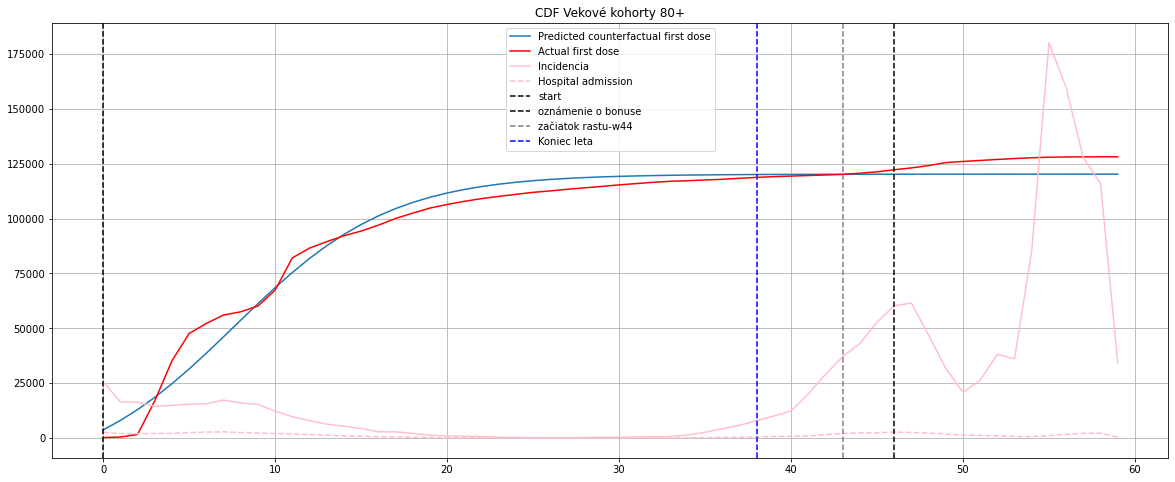

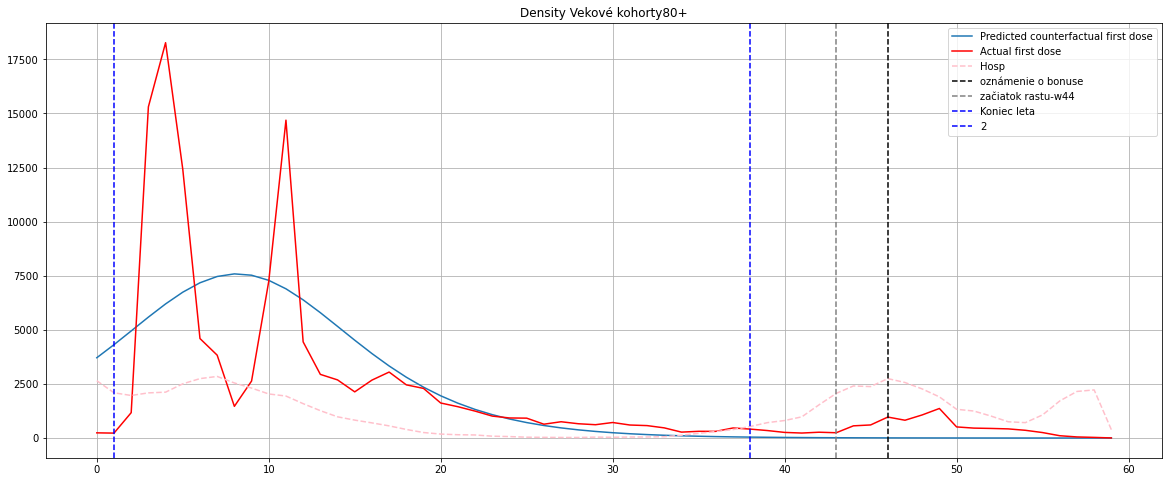

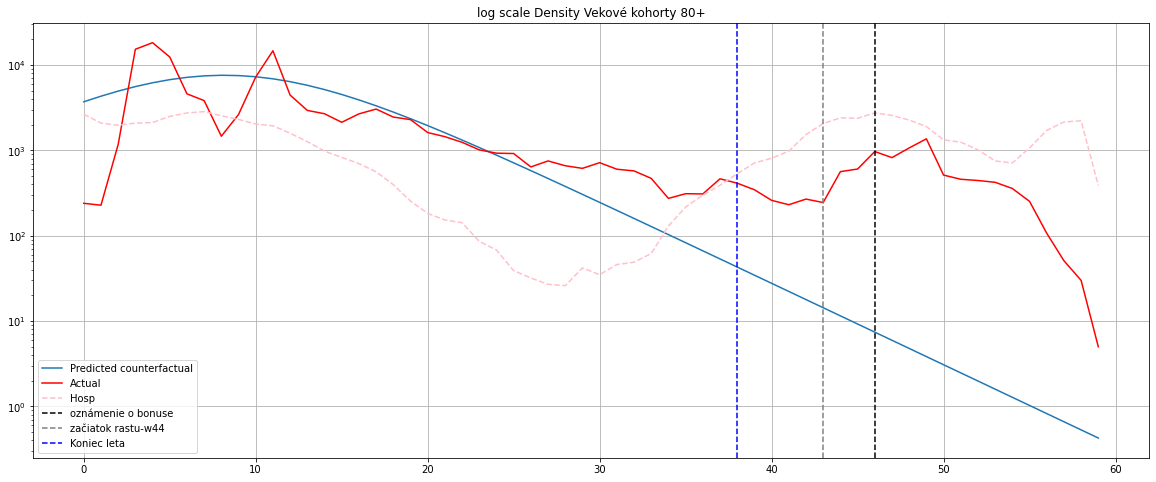

60
hotovo 80+
75-79
p:  0.015132791544927734  q:  0.24520374688587132  m:  115103.48371627403


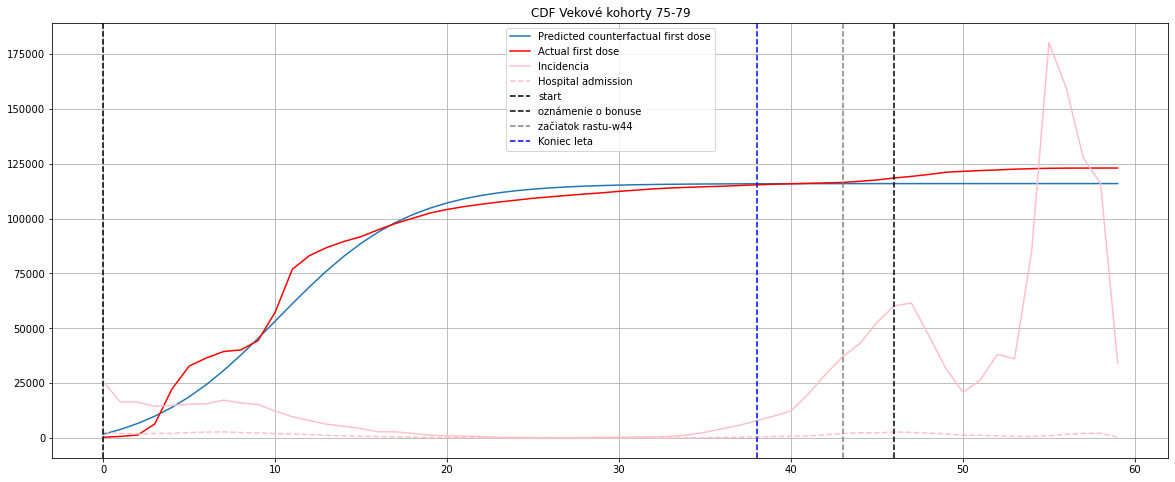

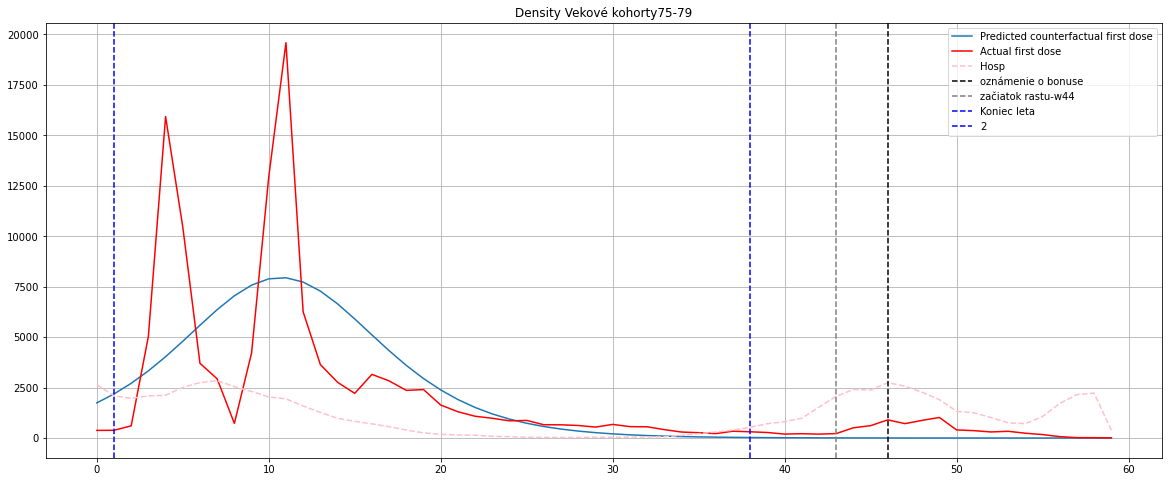

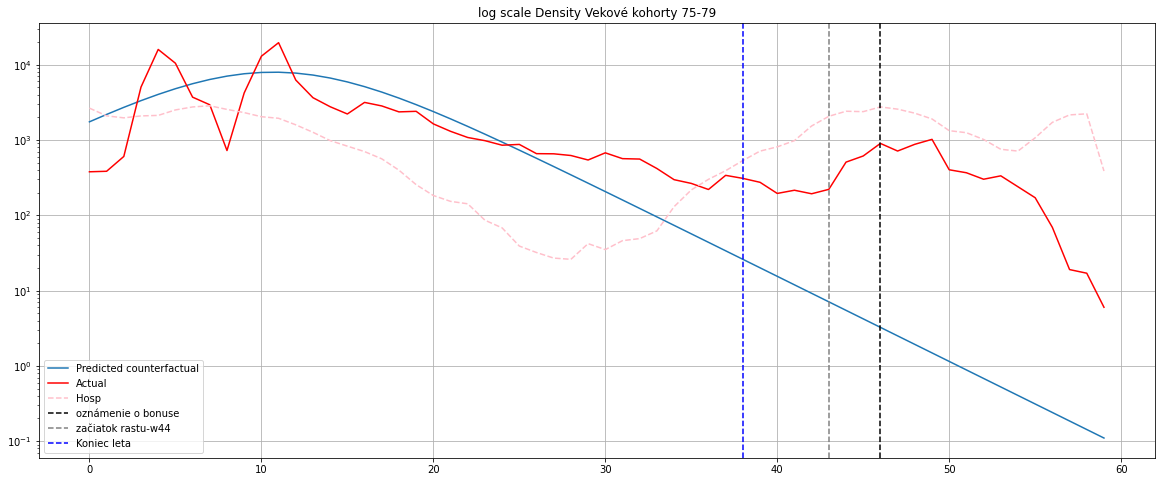

60
hotovo 75-79
70-74
p:  0.039666507854074294  q:  0.3613511978543982  m:  173391.10071396412


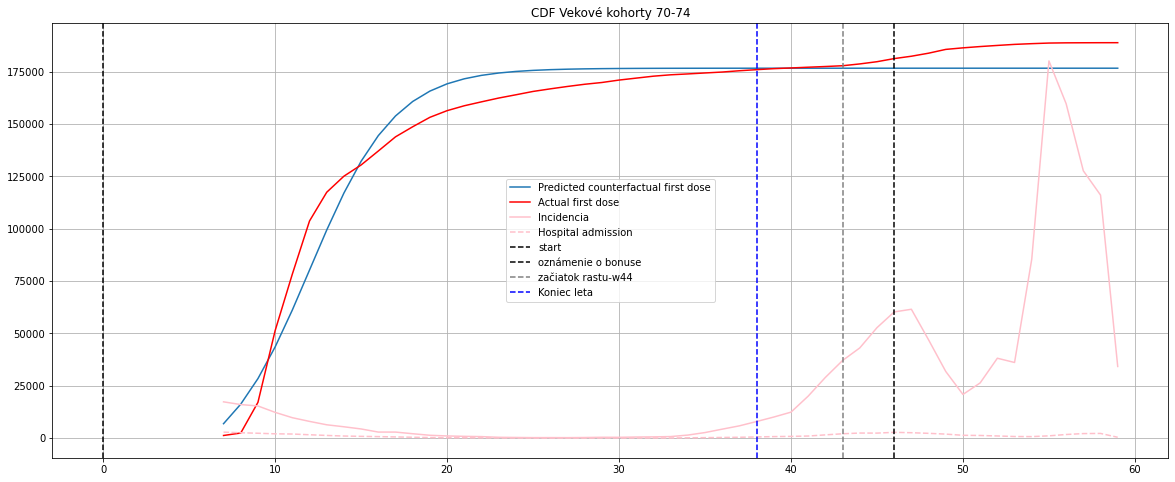

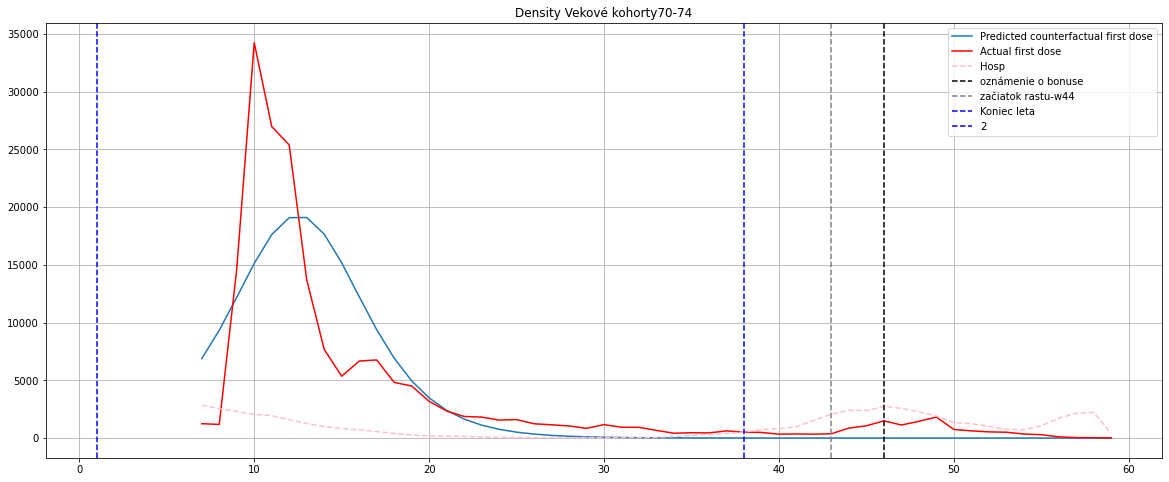

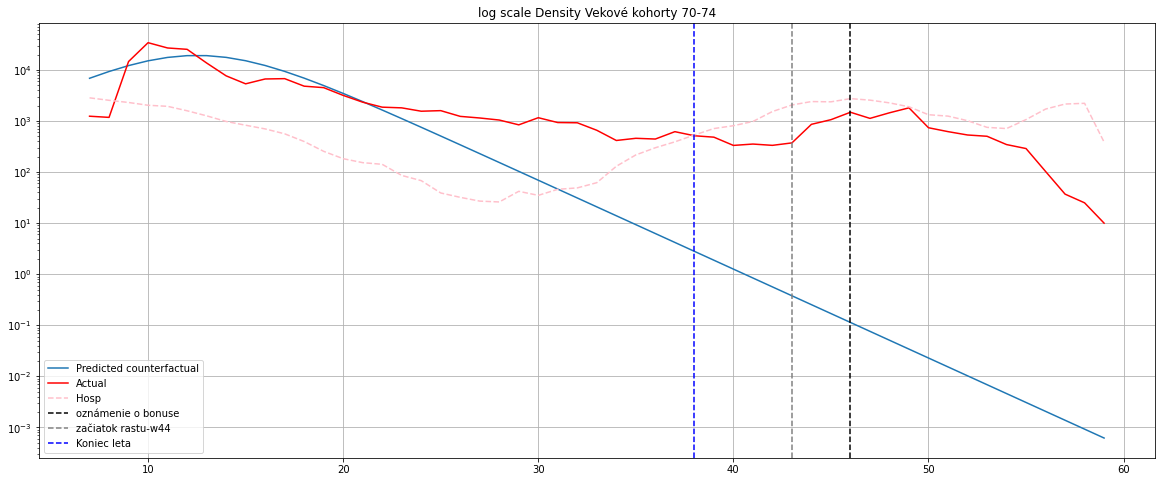

53
hotovo 70-74
65-69
p:  0.030506934223954188  q:  0.2682376170026135  m:  213270.7533657624


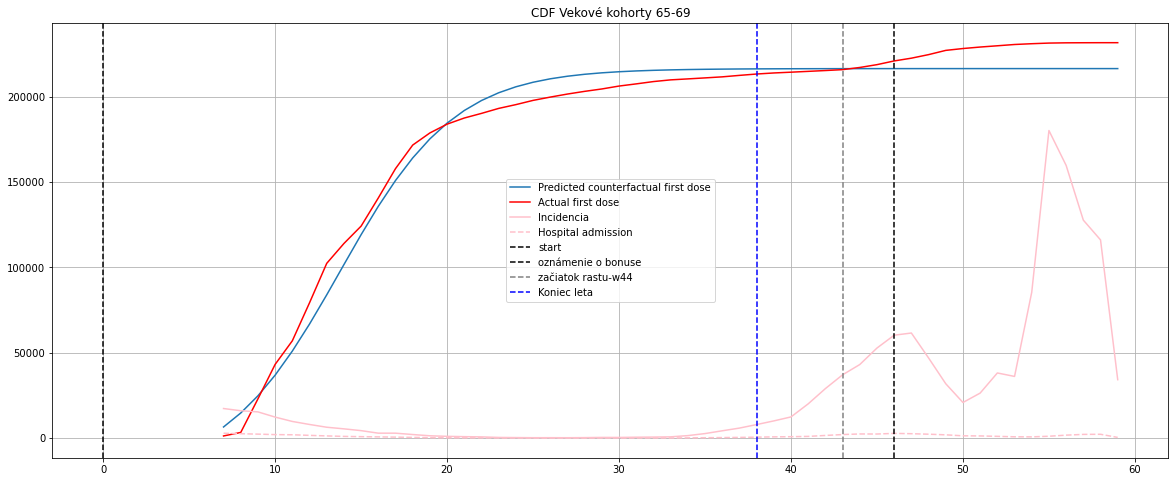

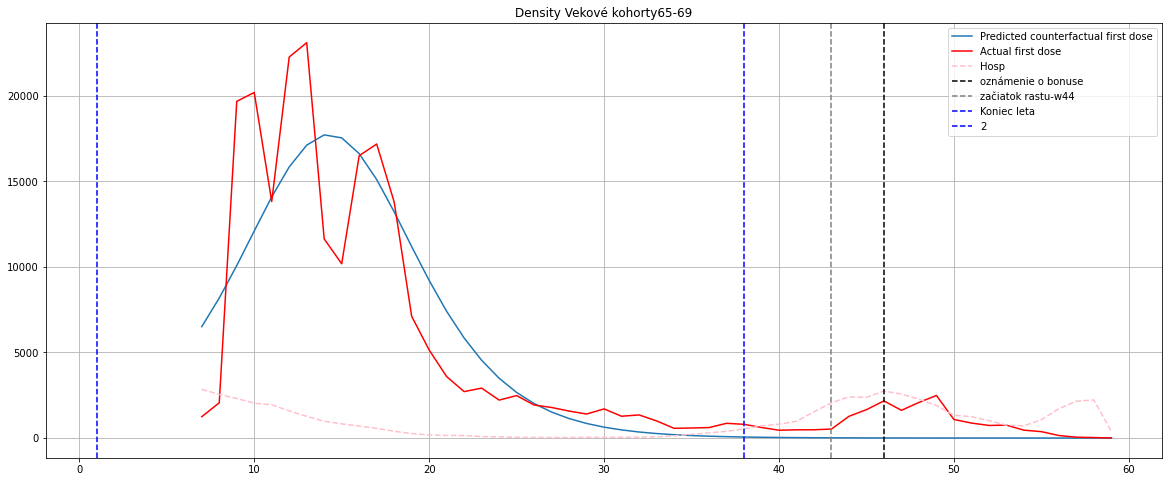

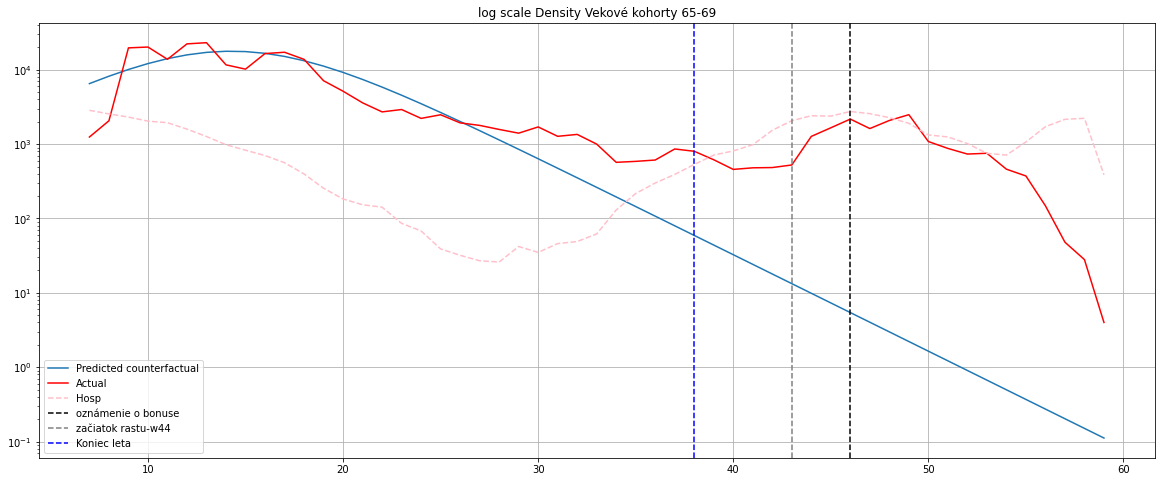

53
hotovo 65-69
60-64
p:  0.024422302714893623  q:  0.21956042546390556  m:  203229.39548189726


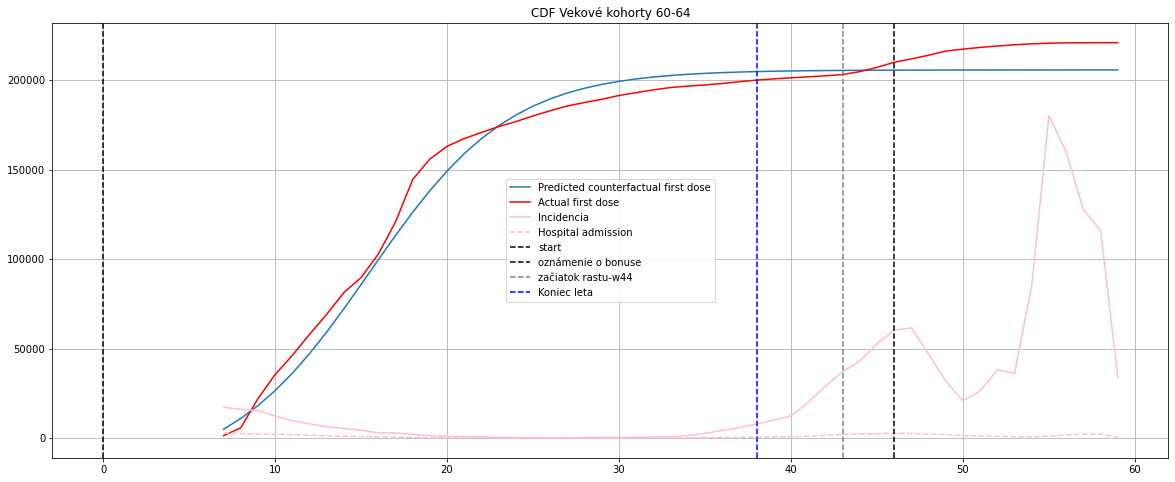

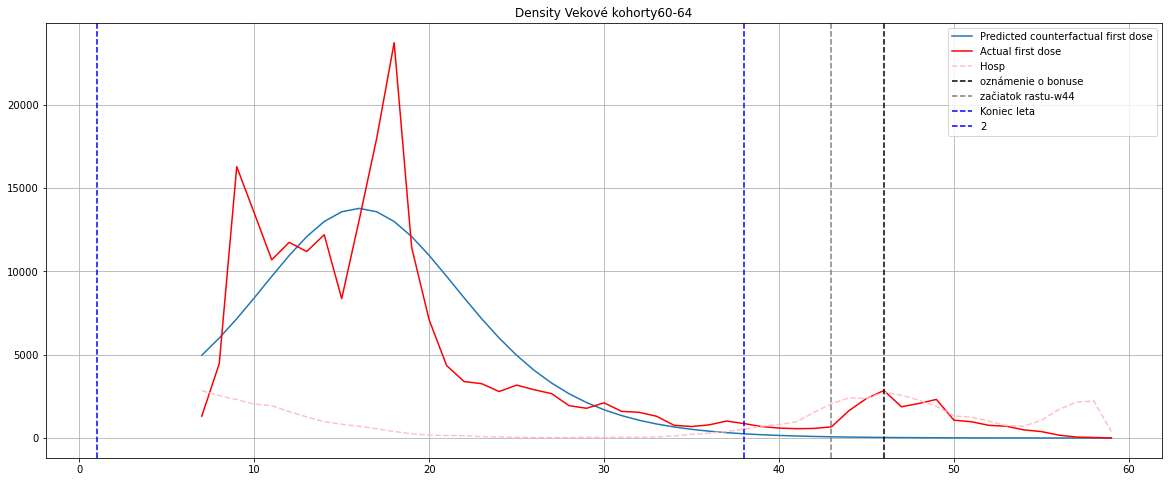

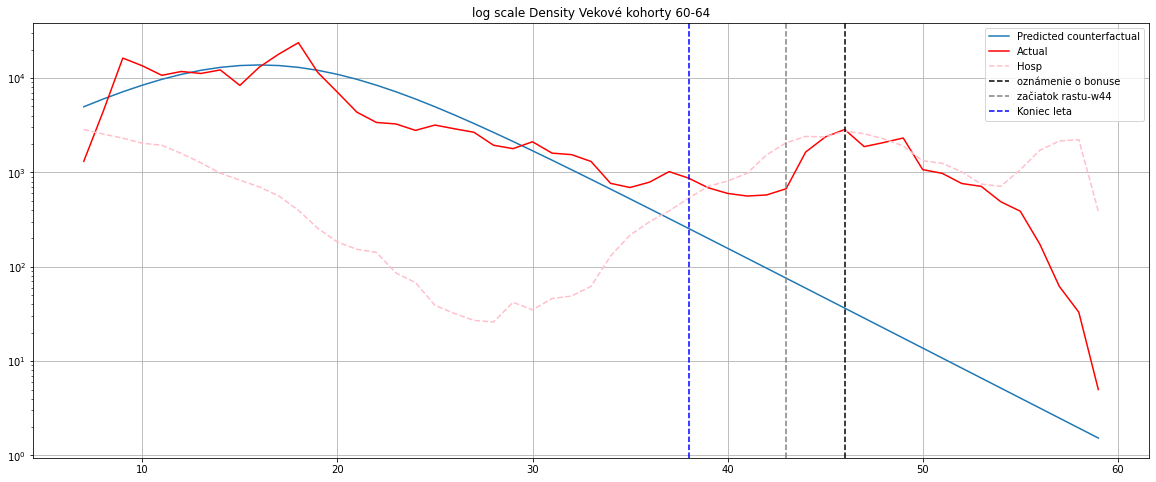

53
hotovo 60-64
55-59
p:  0.022136524780653005  q:  0.1892258147015552  m:  188522.66819477573


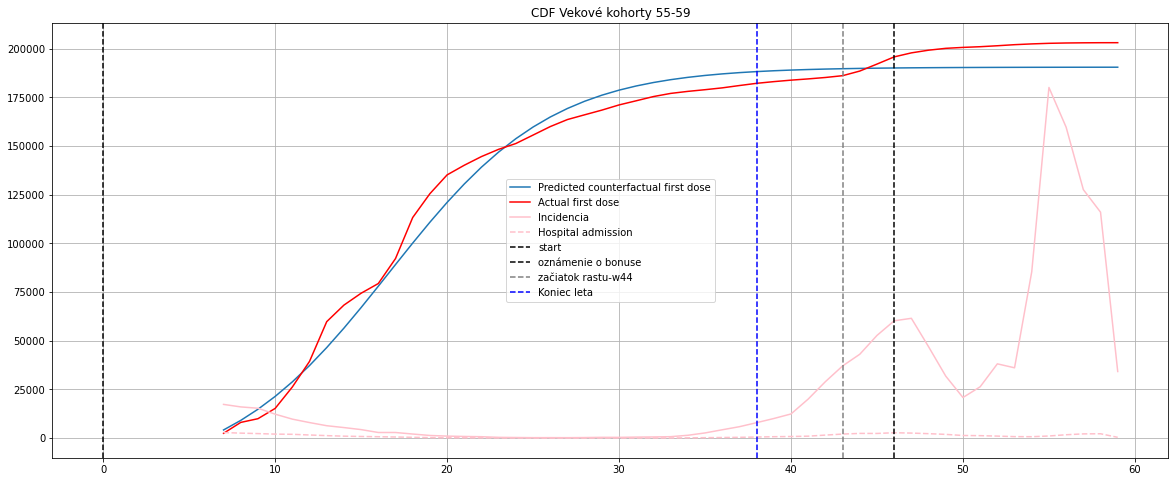

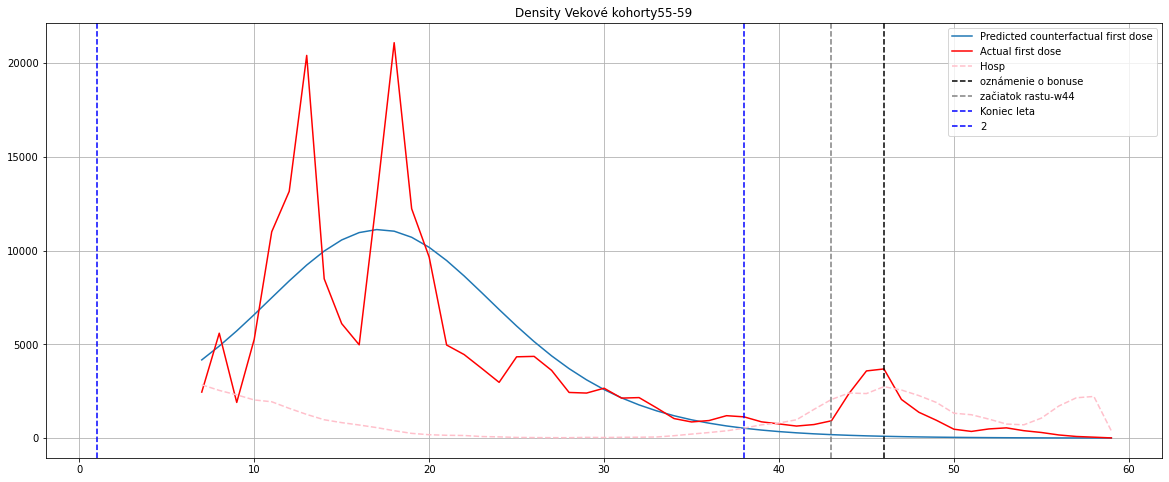

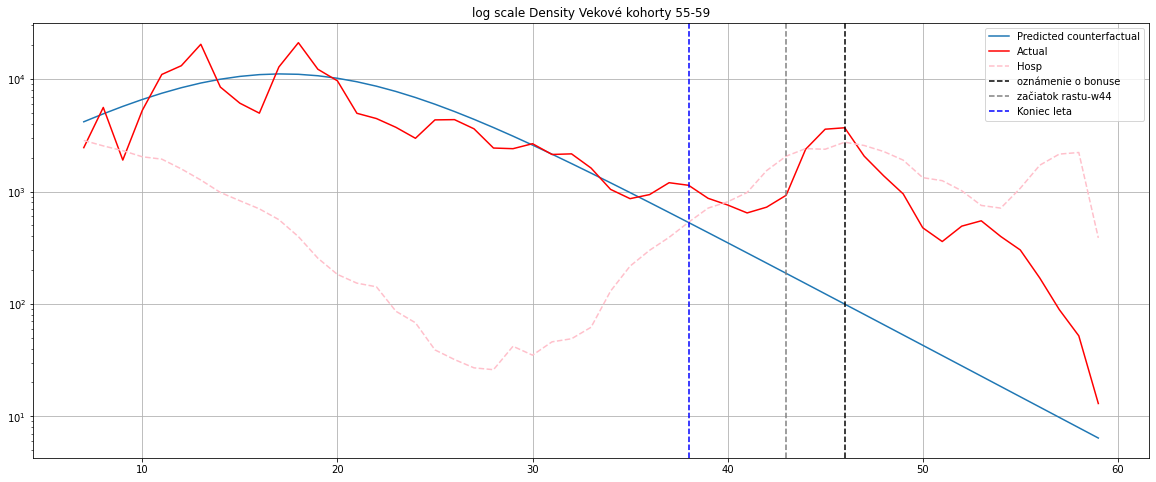

53
hotovo 55-59
50-54
p:  0.017129432687498468  q:  0.1963676598075948  m:  177408.9963326207


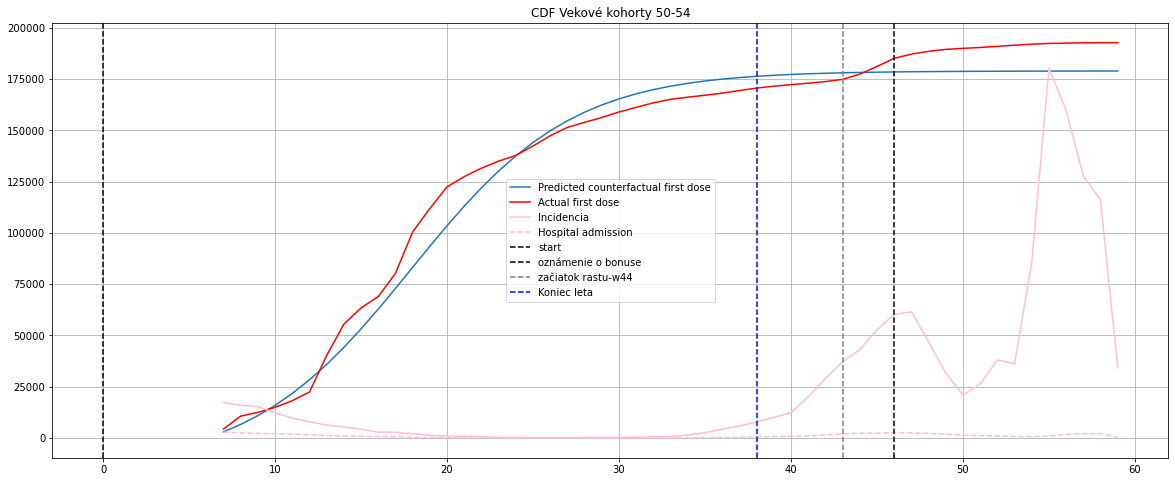

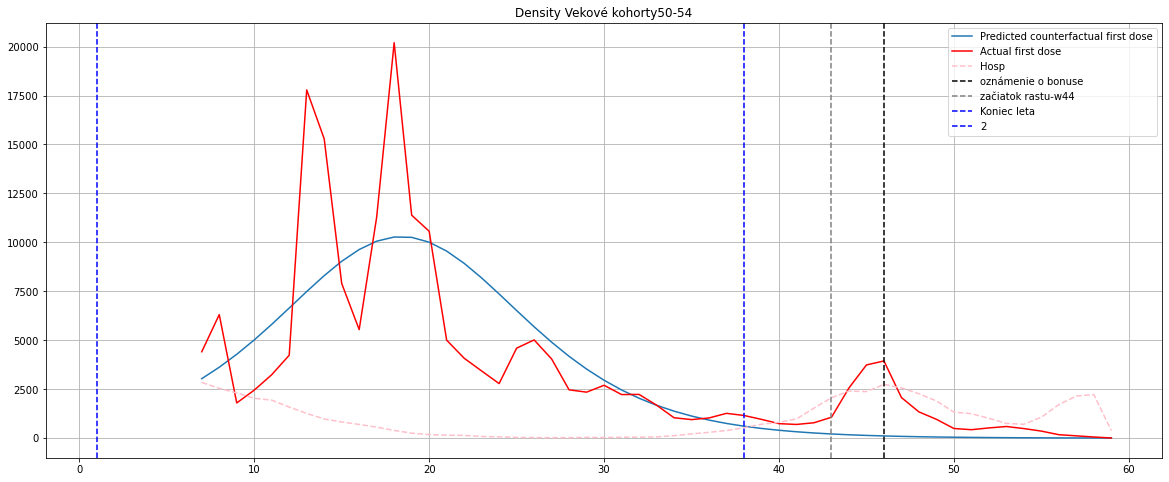

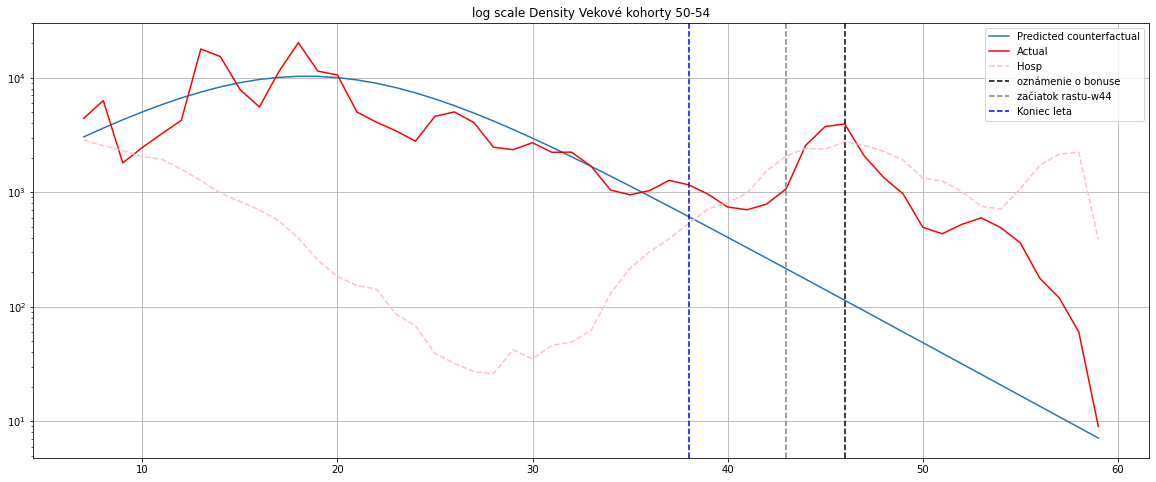

53
hotovo 50-54
45-49
p:  0.026670528695103935  q:  0.19343614271111087  m:  194689.90310079014


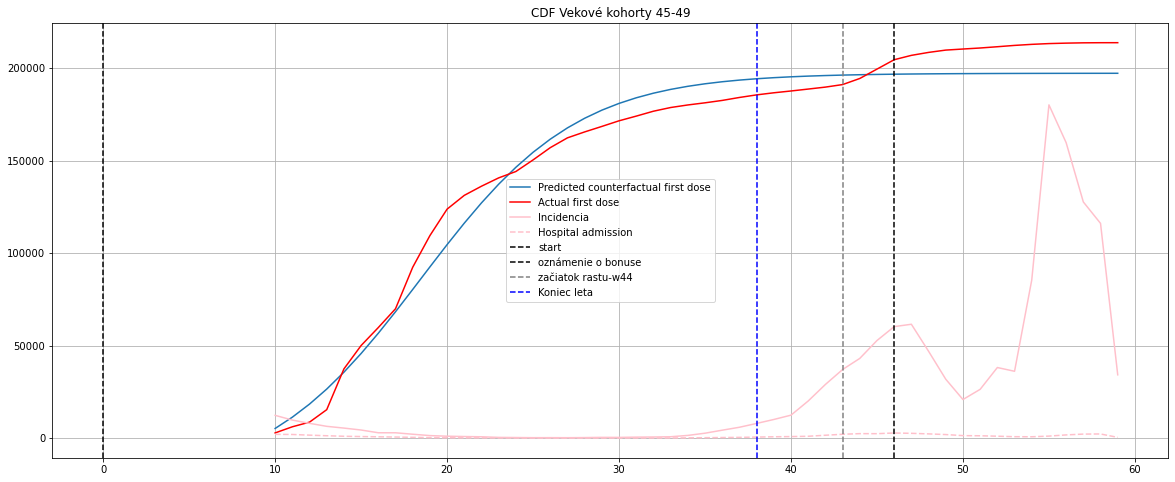

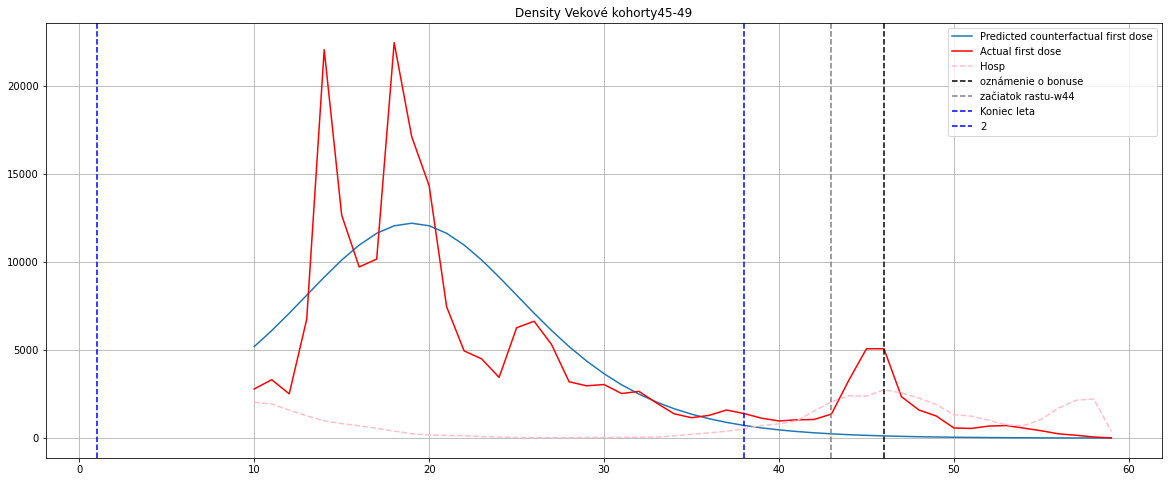

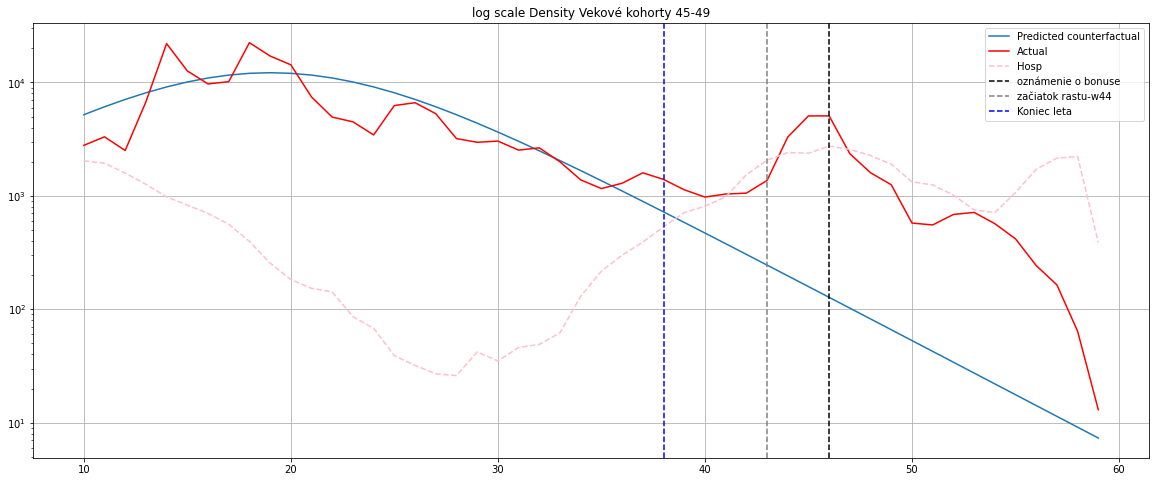

50
hotovo 45-49
40-44
p:  0.020392490674278396  q:  0.2375134322521006  m:  189719.92580162775


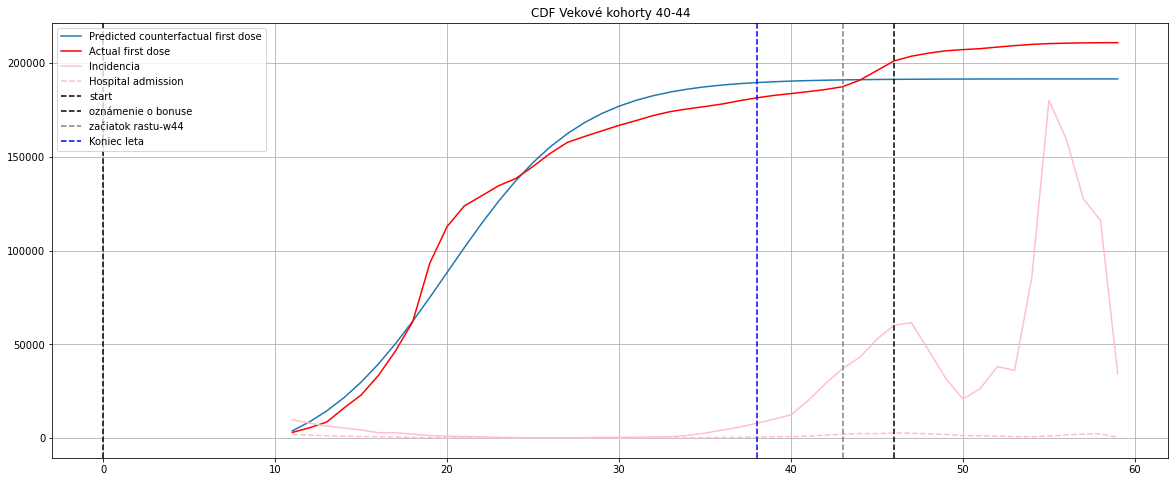

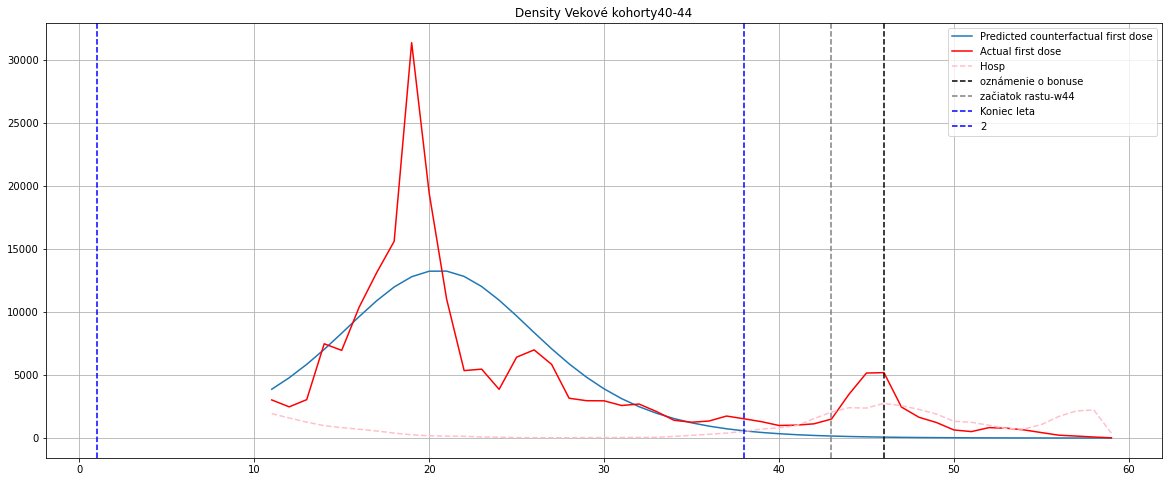

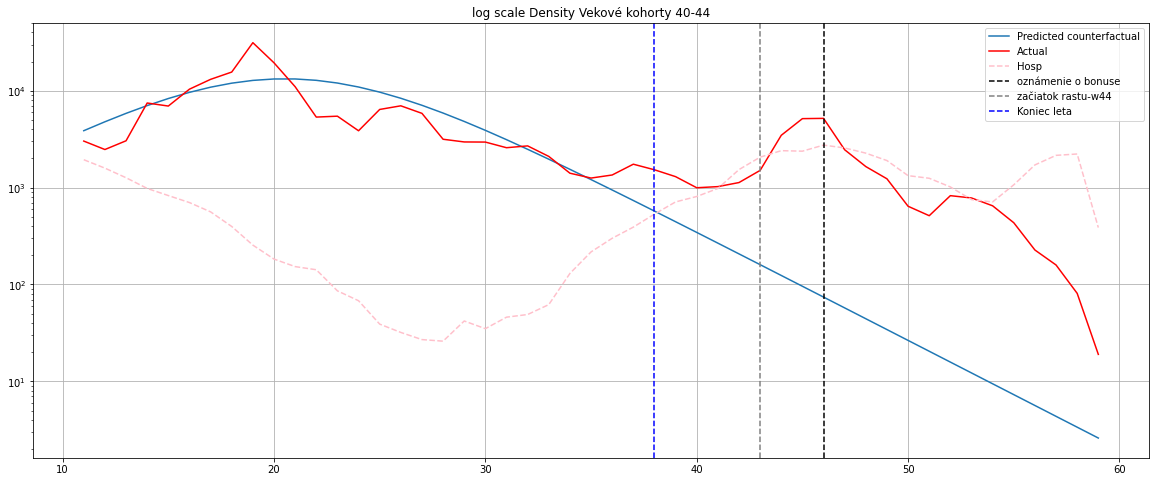

49
hotovo 40-44
35-39
p:  0.02017688329842942  q:  0.24237754978769804  m:  172191.06142060412


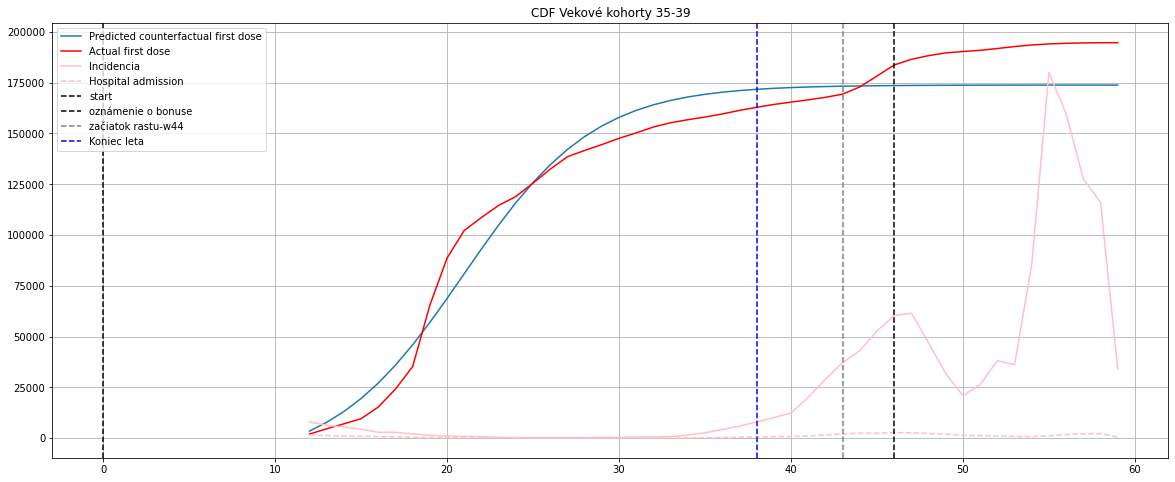

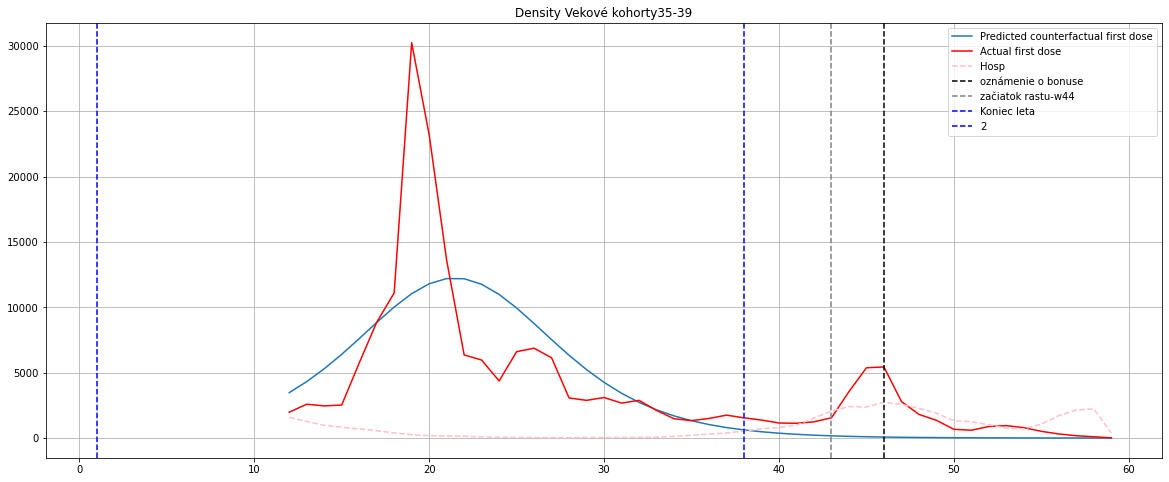

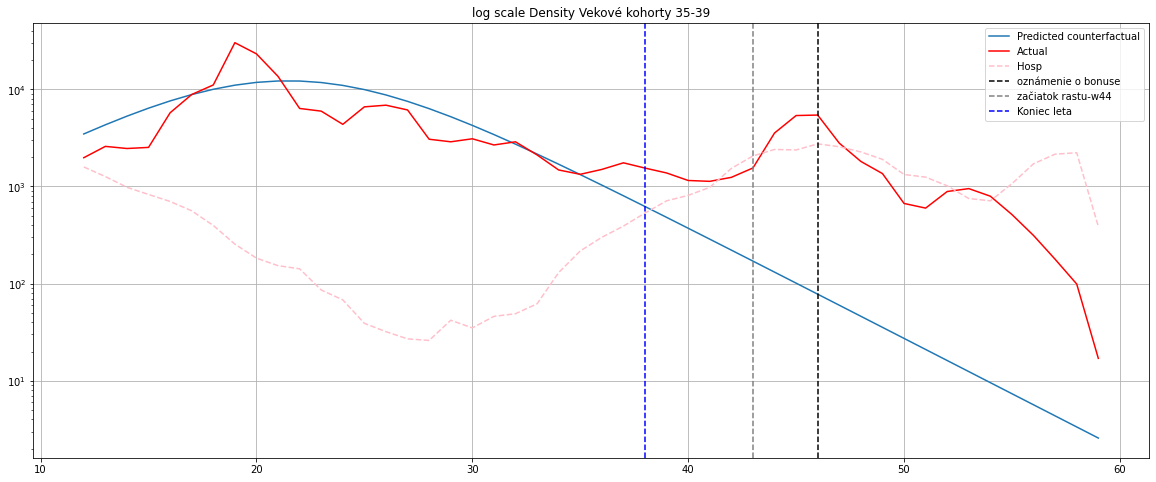

48
hotovo 35-39
30-34
p:  0.02330700876084223  q:  0.21018575903214112  m:  158039.15569300886


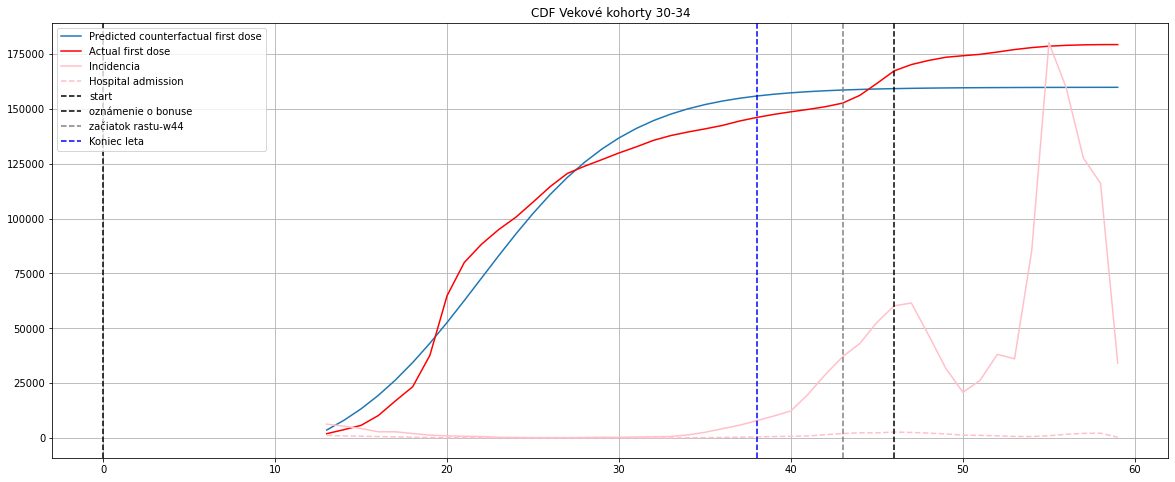

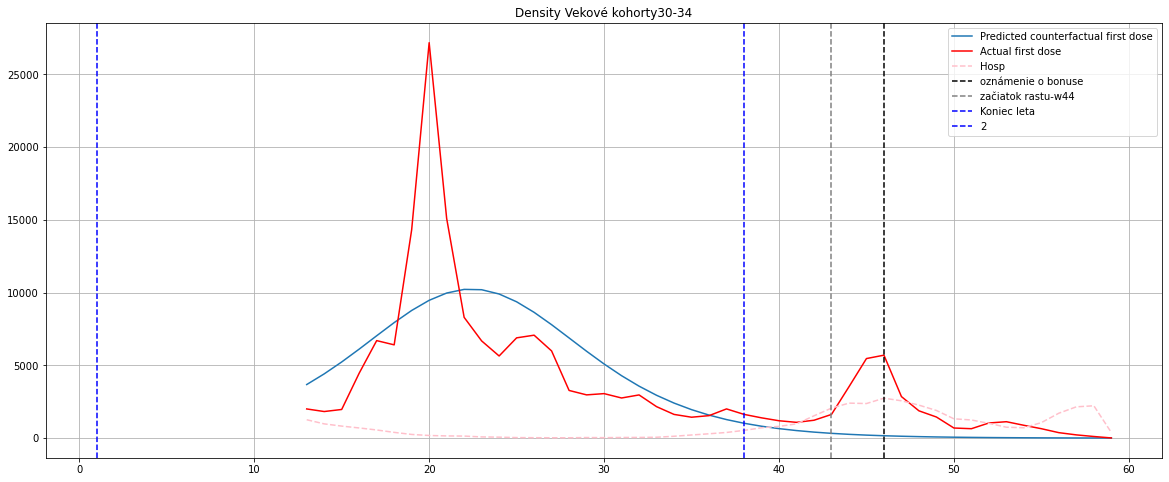

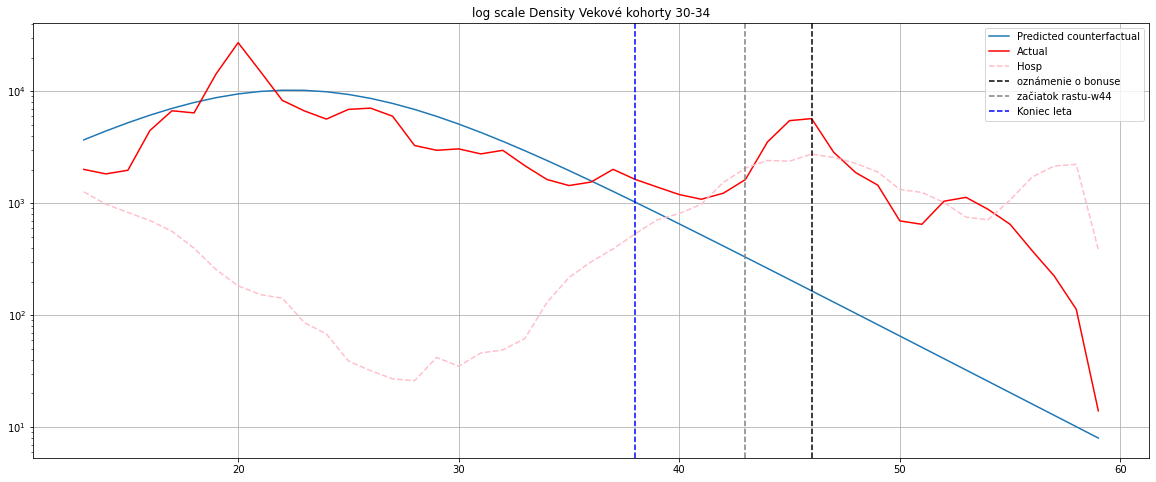

47
hotovo 30-34
25-29
p:  0.0212175522158607  q:  0.1915955612829327  m:  133790.69091338708


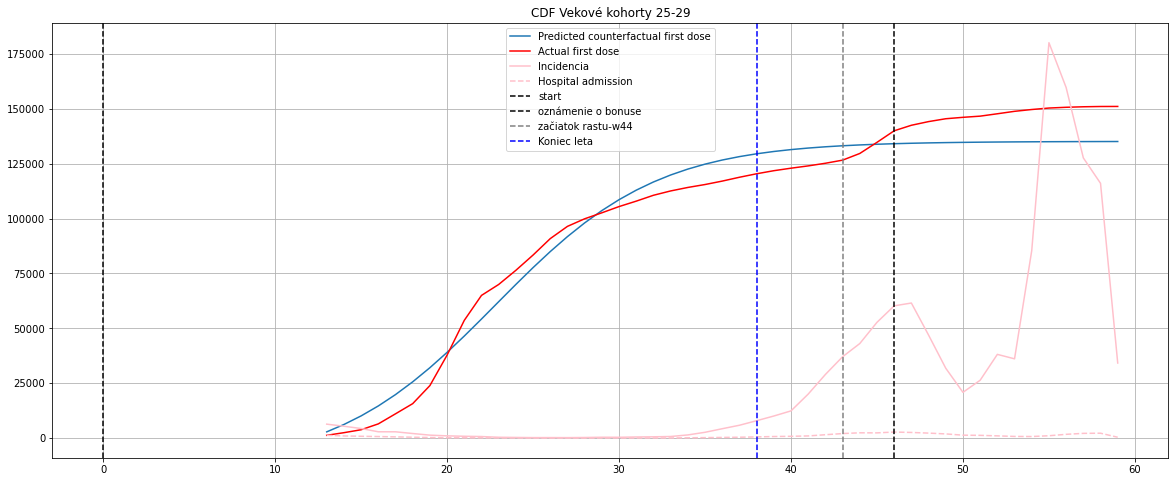

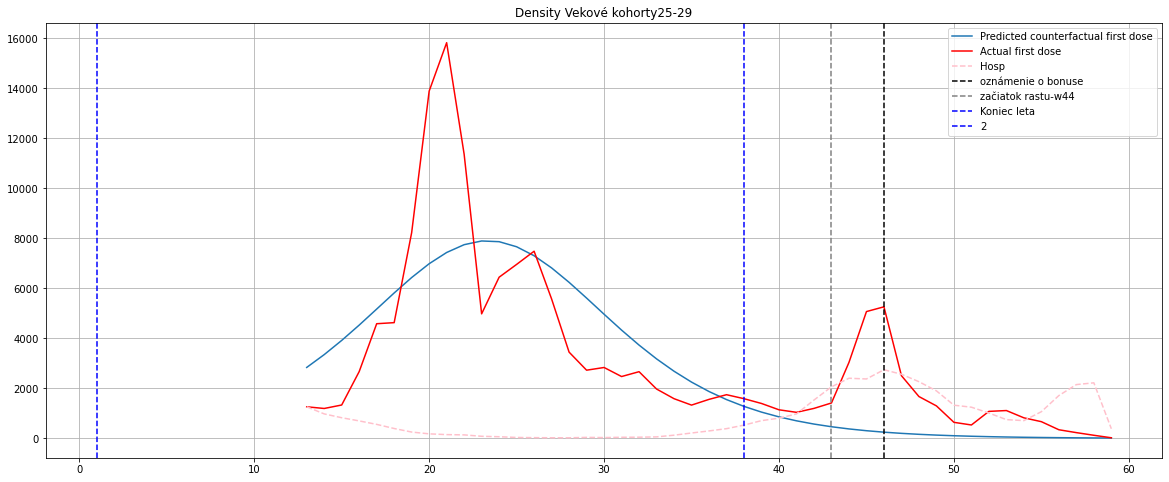

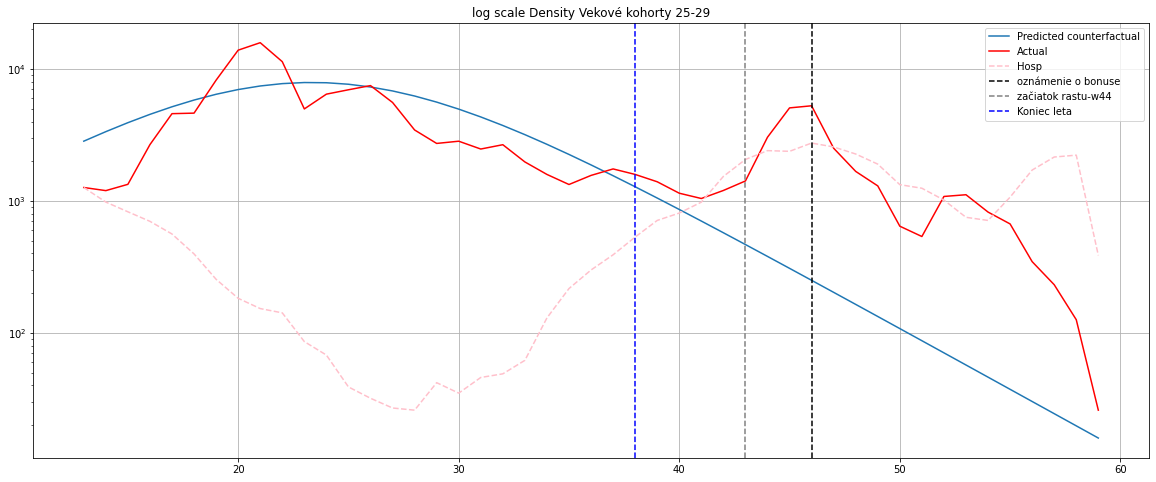

47
hotovo 25-29
20-24
p:  0.017969136694130864  q:  0.19556214418216783  m:  128687.86449657976


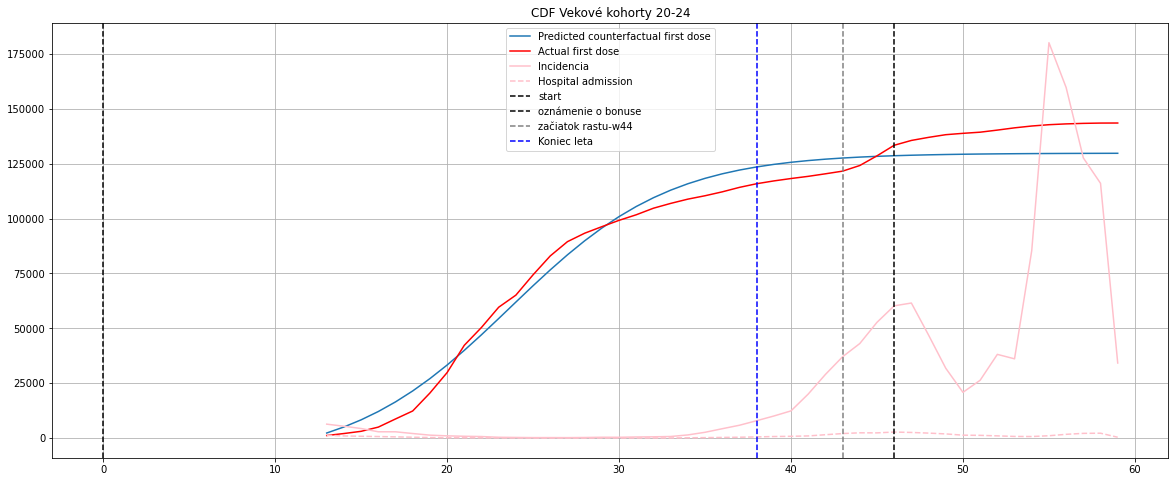

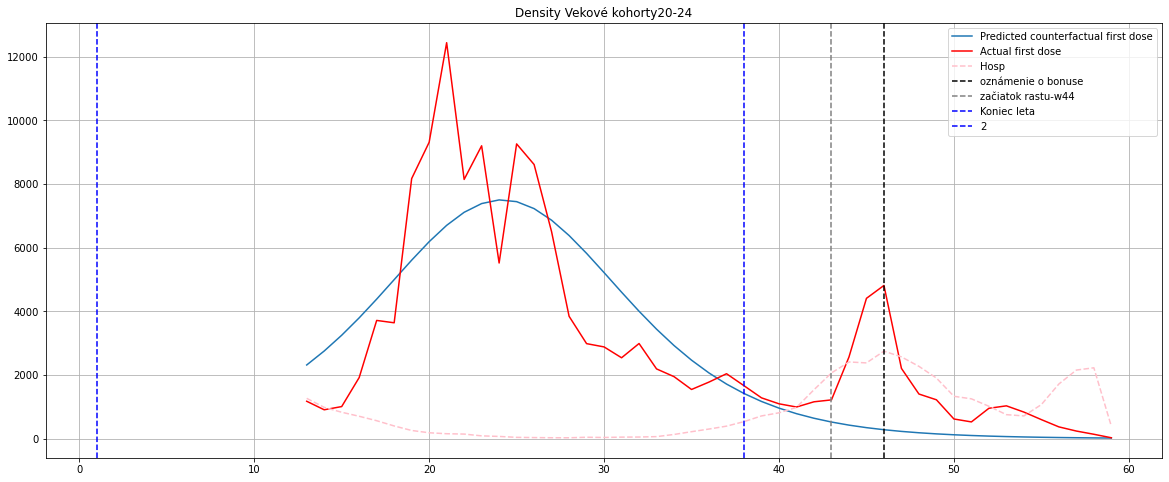

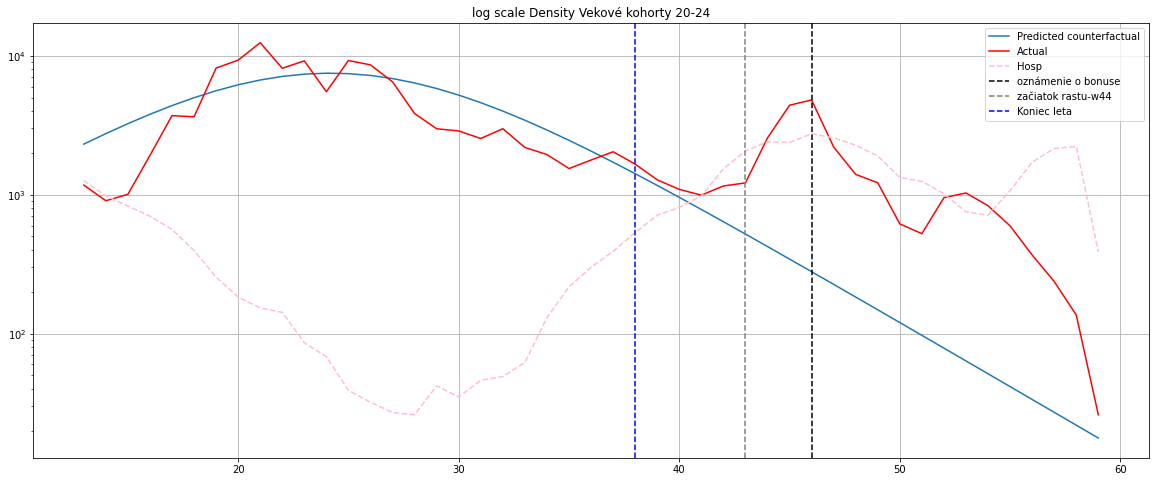

47
hotovo 20-24
60+
p:  0.010283813689510195  q:  0.24744998873188734  m:  854973.6016215209


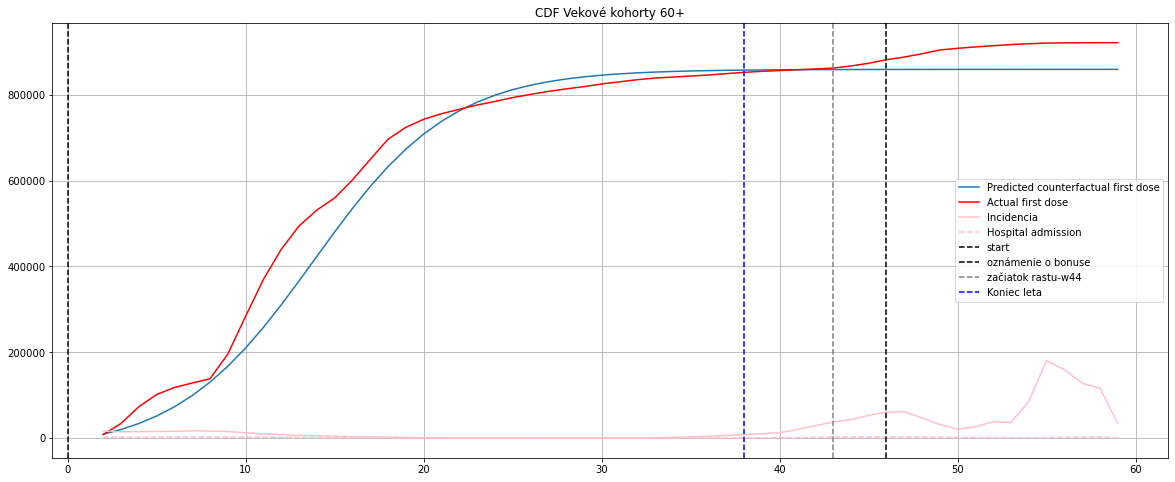

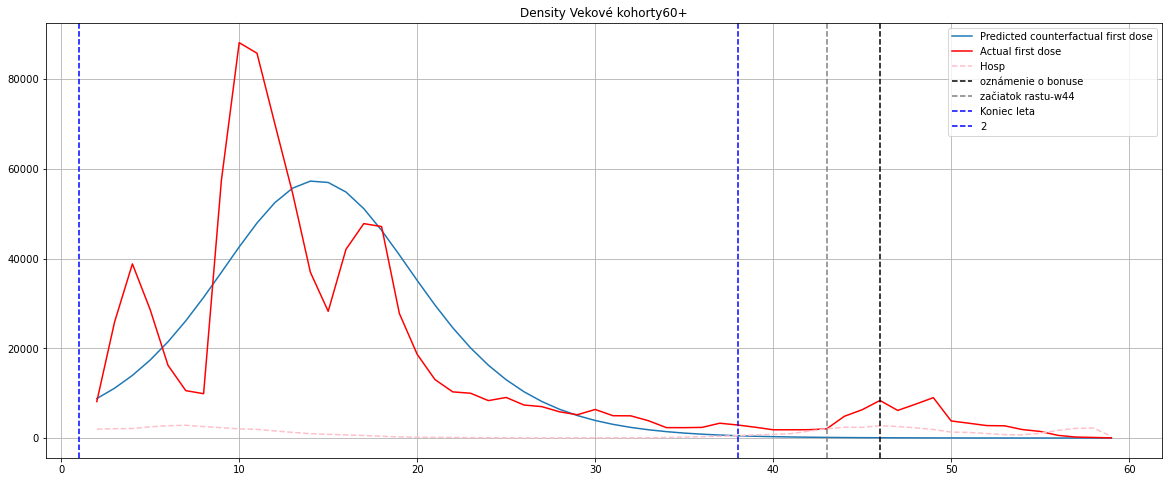

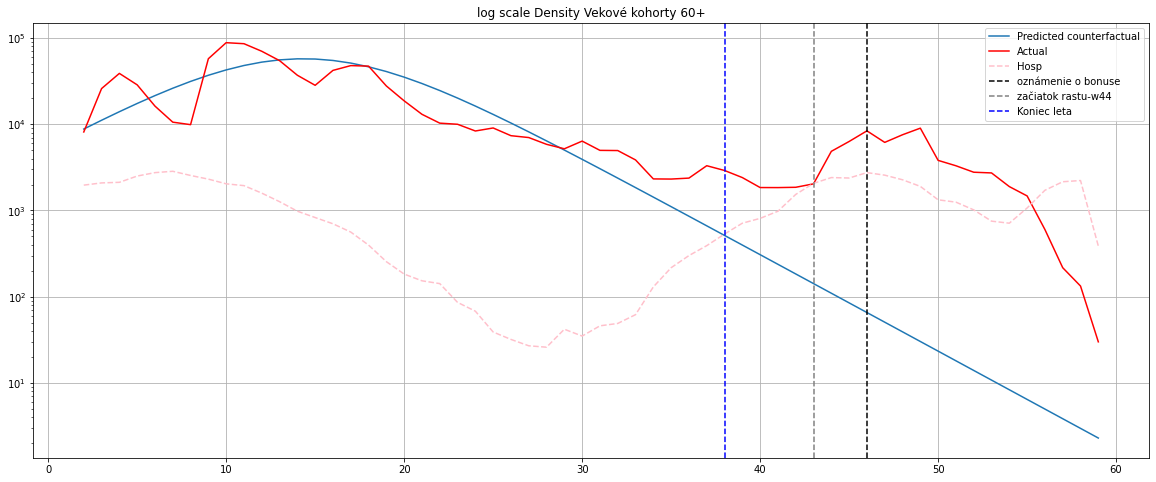

58
hotovo 60+
60-
p:  0.006746514434729365  q:  0.19104781106554258  m:  1481772.8148621216


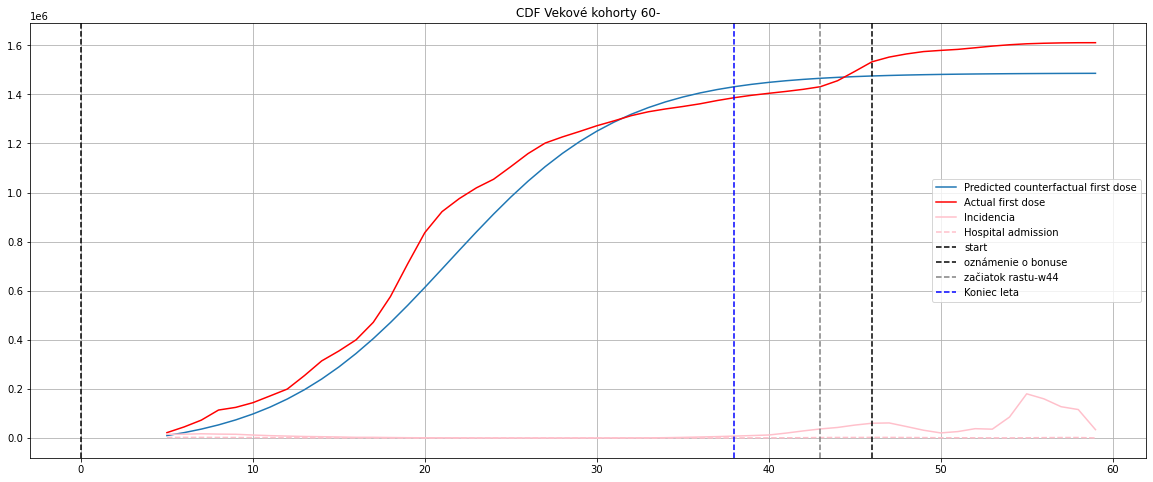

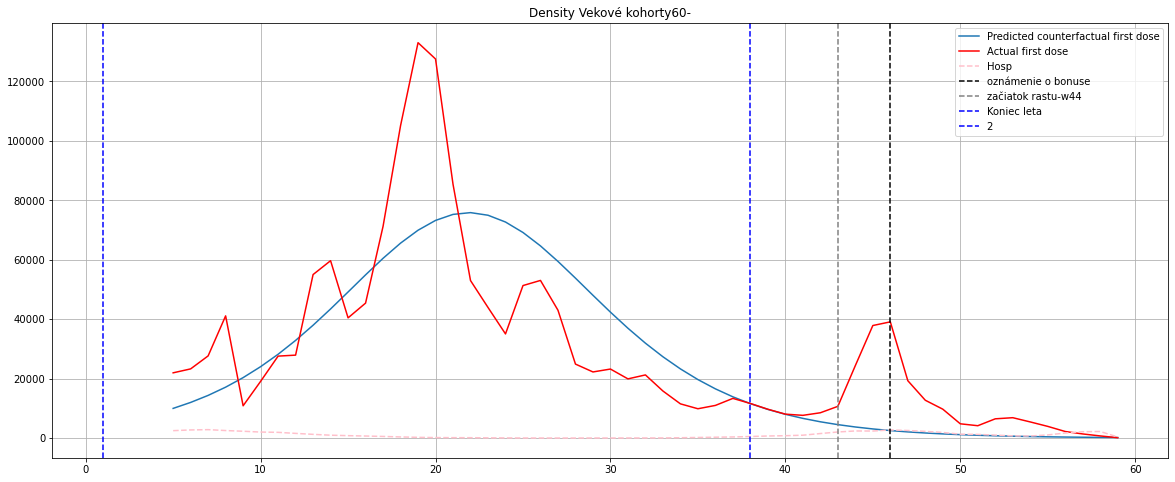

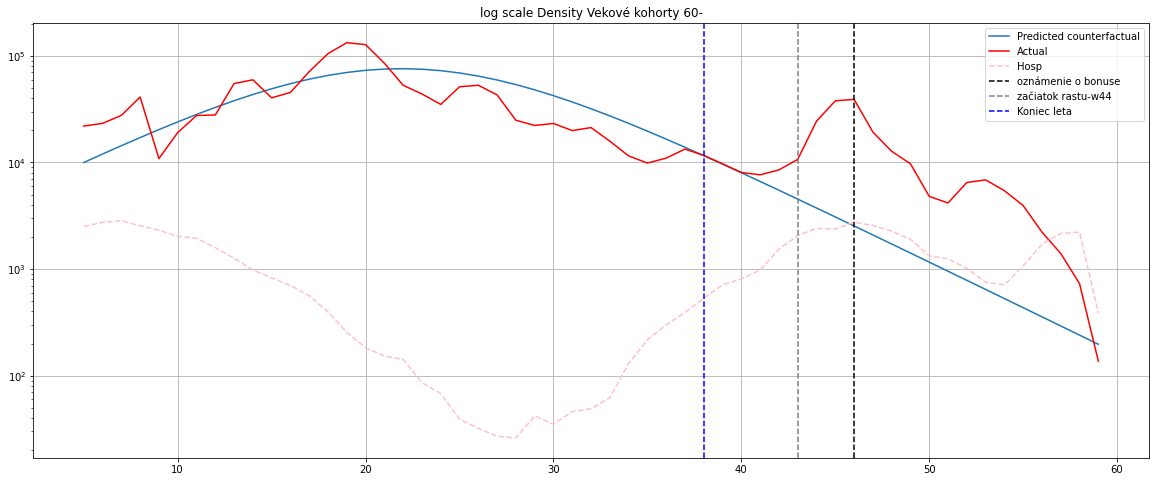

55
hotovo 60-
15352.241031804564


In [13]:
# This part of the code is determined for the evaluation of the bonus itself and to see observed fit of the model
# Generally there are only modeling bass model for each age group and put the result to the belonging list and making dataframe from the list. 
# the result should be in ...
df_bk=pd.DataFrame(Bass_setup())
df_bk=pd.merge(df_bk, pop, how="left",on=["AgeGroup"]) #merging dataset containing bass setup and population data
#definition of lists which will be append to dataframe 

real_w47=[]
real_w57=[]
#list_rozdiely=[]
#list_rozdiel_abs=[]
df_bk['cum sum 47']=''
list_w47=[]
df_bk['cum sum 57']=''
list_w57=[]
sucet_k=[]
#list_rozdiely=[]
#bass model calculation for each of the agegroup the result of some important variables are stored in the list after for cycle lists are appended to the dataframe 

for x in df_bk['AgeGroup']:       #filling the lists by data 
    print(x)
    bass(x)
    #list_rozdiely.append(int(rozdiel1))
    real_w57.append(graf_2[55])
    real_w47.append(graf_2[46])
    list_w47.append(cdf[xyz])
    list_w57.append(cdf[xyz+9])
    #list_rozdiel_abs.append(int(rozdiel))
    sucet_k.append(int(sucet_prvych))
    print ('hotovo', x)
    
#lists to DF
df_bk['sucet_k']=sucet_k 
df_bk['cum sum 47']=real_w47 + df_bk['sucet_k']
df_bk['cum sum 56']=real_w57 + df_bk['sucet_k']
df_bk['w47for']=list_w47
df_bk['w57for']=list_w57

#some basic calculation, to obtain the result of newly vaccinated people due to bonus 
df_bk['rozdiel']=df_bk['cum sum 56']-df_bk['w57for']-df_bk['sucet_k'] #real-forecast
df_bk['rozdiel%']=df_bk['rozdiel']/df_bk['populacia'] # %of vaccinated from total population from 47th week
df_bk['roz neoc w47']=df_bk['rozdiel']/(df_bk['populacia']-df_bk['cum sum 47']) # % vaccinated from unvaccinated till 47th week
df_bk['rozdiel_abs']=df_bk['cum sum 56']-df_bk['cum sum 47'] #absolute number of newly vaccinated
avg60p=np.average((df_bk['roz neoc w47'].loc[:4]),weights=df_bk['populacia'].loc[:4])   #weighted average of % vaccinated from unvaccinated till 47th week (60+) #df_bk['roz neoc w47'].loc[:4].mean()
avg50m=np.average((df_bk['roz neoc w47'].loc[5:12]),weights=df_bk['populacia'].loc[5:12]) #weighted average of % vaccinated from unvaccinated till 47th week (60-)
realnazaockovanost60=df_bk['rozdiel_abs'].loc[:4].sum() #how many people were jabbed between the roll out of the policy and end of the policy
efekt_opatrenia=(avg60p-avg50m)/avg60p*realnazaockovanost60

#vysledok= efekt_opatrenia + ' newly vaccinated people due to bonus'

print(efekt_opatrenia) 
#df_bk['rozdiel*pop']=df_bk.rozdiel*df_bk.populacia
#avg_nad_60=((df_bk['rozdiel*pop'].head(5).sum())/(df_bk.loc[df_bk.AgeGroup=='60+','populacia'].values[0]))
#avg_50_59=((df_bk['rozdiel*pop'].iloc[5:7].sum())/(df_bk['populacia'].iloc[5:7].sum()))



In [14]:
df_bk

,AgeGroup,zac,populacia,sucet_k,cum sum 47,cum sum 56,w47for,w57for,rozdiel,rozdiel%,roz neoc w47,rozdiel_abs
0,80+,0,189121,0,122250,127958,1.202159e+05,1.202368e+05,7721.189726,0.040827,0.115464,5708
1,75-79,0,160295,0,118488,122910,1.159326e+05,1.159402e+05,6969.788306,0.043481,0.166713,4422
2,70-74,7,247632,10726,191963,199383,1.766455e+05,1.766456e+05,12011.399357,0.048505,0.215765,7420
3,65-69,7,334976,13441,234315,244777,2.163834e+05,2.163942e+05,14941.828101,0.044606,0.148437,10462
4,60-64,7,353682,18296,228205,238870,2.055269e+05,2.056188e+05,14955.176375,0.042284,0.119187,10665
5,55-59,7,356041,20921,216745,223716,1.902075e+05,1.904998e+05,12295.183247,0.034533,0.088267,6971
6,50-54,7,345716,22336,207350,214626,1.784960e+05,1.788263e+05,13463.687560,0.038944,0.097305,7276
7,45-49,10,414217,41225,245747,254467,1.967975e+05,1.971564e+05,16085.572270,0.038834,0.095480,8720
8,40-44,11,453932,38399,239618,248805,1.913893e+05,1.915652e+05,18840.800467,0.041506,0.087912,9187
9,35-39,12,433922,32589,216326,226703,1.736640e+05,1.738450e+05,20268.953703,0.046711,0.093149,10377


In [15]:
print((avg60p-avg50m)/avg60p)
print('Effect of the policy: ',round(efekt_opatrenia), ) 

0.3969346389793563
Effect of the policy:  15352
